In [1]:
# needed libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from plotter2 import custom_parallel_coordinates
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
from matplotlib.markers import MarkerStyle


In [2]:
principle_colors = {
    'None': "#808080",
    'uwf': "#F97306",
    'pwf': "#DDA0DD",
    'gini': "#32CD32", 
}

# 1. Data Preperation

## 1.1 Data Collection

In [3]:
# Define the subfolder names corresponding to different experiments.
subfoldernames = ["nfe50000_None_001_demand", "nfe50000_uwf_001_demand", "nfe50000_pwf_100_demand", "nfe50000_gini_01_demand"]

In [4]:
def get_principle(s):
    for principle in ["None", "uwf", "pwf", "gini"]:
        if principle in s:
            return principle
    raise ValueError("Invalid string, principle not recognized.")

In [5]:
results = {}
for subfolder in subfoldernames:
    opt_results = pd.read_csv(f"../outputs/{subfolder}/baseline_results_{subfolder}.csv", index_col=[0])
    principle = get_principle(subfolder)
    results[principle] = opt_results

In [6]:
# Displaying shape of each dataframe
for key, df in results.items():
    print(f"\nPrinciple: {key}")
    print(f"Shape: {df.shape}")


Principle: None
Shape: (207, 170)

Principle: uwf
Shape: (219, 171)

Principle: pwf
Shape: (238, 171)

Principle: gini
Shape: (338, 171)


## 1.2 Data Cleaning

In [7]:
policy_results = {}
objective_results = {}

for key, df in results.items():
    if key == "None":
        split_point = -6
    else:
        split_point = -7
    
    policies, objectives = df.iloc[:, :split_point], df.iloc[:, split_point:]
    policy_results[key] = policies
    objective_results[key] = objectives
    # Printing shape information
    print(f"Principle: {key}")
    print(f"Shape of policies: {policies.shape}")
    print(f"Shape of objectives: {objectives.shape}\n")

Principle: None
Shape of policies: (207, 164)
Shape of objectives: (207, 6)

Principle: uwf
Shape of policies: (219, 164)
Shape of objectives: (219, 7)

Principle: pwf
Shape of policies: (238, 164)
Shape of objectives: (238, 7)

Principle: gini
Shape of policies: (338, 164)
Shape of objectives: (338, 7)



In [8]:
# Concatenate all the dataframes in objective_results into one dataframe
df_experiments = pd.concat(objective_results, names=["Principle", "Index"])
df_experiments

egypt_agg_deficit_ratio  egypt_90p_deficit_ratio  \
Principle Index                                                     
None      0                     0.059863                 0.189728   
          1                     0.062170                 0.188981   
          2                     0.064460                 0.198946   
          3                     0.061862                 0.189675   
          4                     0.064488                 0.198994   
...                                  ...                      ...   
gini      333                   0.058888                 0.185044   
          334                   0.269800                 1.000000   
          335                   0.048625                 0.152609   
          336                   0.099155                 0.162350   
          337                   0.056078                 0.176157   

                 egypt_low_had_frequency  sudan_agg_deficit_ratio  \
Principle Index                                                     
None      0                     0.137500                 0.447351   
          1                     0.183333                 0.464333   
          2                     0.020833                 0.602078   
          3                     0.383333                 0.442585   
          4                     0.037500                 0.509928   
...                                  ...                      ...   
gini      333                   0.262500                 0.383202   
          334                   0.900000                 0.434169   
          335                   0.195833                 0.686921   
          336                   0.700000                 0.645428   
          337                   0.095833                 0.493905   

                 sudan_90p_deficit_ratio  ethiopia_agg_deficit_ratio  \
Principle Index                                                        
None      0                     0.887193                    0.775475   
          1                     0.740000                    0.749739   
          2                     0.897248                    0.721120   
          3                     0.754036                    0.746443   
          4                     0.732470                    0.742275   
...                                  ...                         ...   
gini      333                   0.875075                    0.849522   
          334                   0.892256                    0.820905   
          335                   0.903032                    0.757236   
          336                   0.905318                    0.768033   
          337                   0.886140                    0.813899   

                 principle_result  
Principle Index                    
None      0                   NaN  
          1                   NaN  
          2                   NaN  
          3                   NaN  
          4                   NaN  
...                           ...  
gini      333            0.605042  
          334            0.802344  
          335            0.600559  
          336            0.700105  
          337            0.562370  

[1002 rows x 7 columns]

## 1.3 Exploratory Data Analysis

In [9]:
# Determine the number of principles and objectives
num_principles = len(objective_results.keys())
first_principle = list(objective_results.keys())[0]
num_objectives = objective_results[first_principle].shape[1]

In [10]:
# # Create subplots
# fig, axes = plt.subplots(num_principles, num_objectives, figsize=(15, 5 * num_principles), sharex=False, sharey=False)

# for p_idx, (principle, objectives_df) in enumerate(objective_results.items()):
#     for o_idx in range(num_objectives):
#         ax = axes[p_idx][o_idx] if num_principles > 1 else axes[o_idx]
        
#         # Check if this principle has data for the current objective
#         if o_idx < objectives_df.shape[1]:
#             objective_column = objectives_df.columns[o_idx]
#             sns.histplot(objectives_df[df.columns][objective_column], ax=ax, kde=True, bins=30)
#             if p_idx == 0:
#                 ax.set_title(objective_column)
#         else:
#             ax.axis("off")  # Turn off axes for empty plots
        
#         if o_idx == 0:
#             ax.set_ylabel(principle)

# plt.tight_layout()
# plt.show()


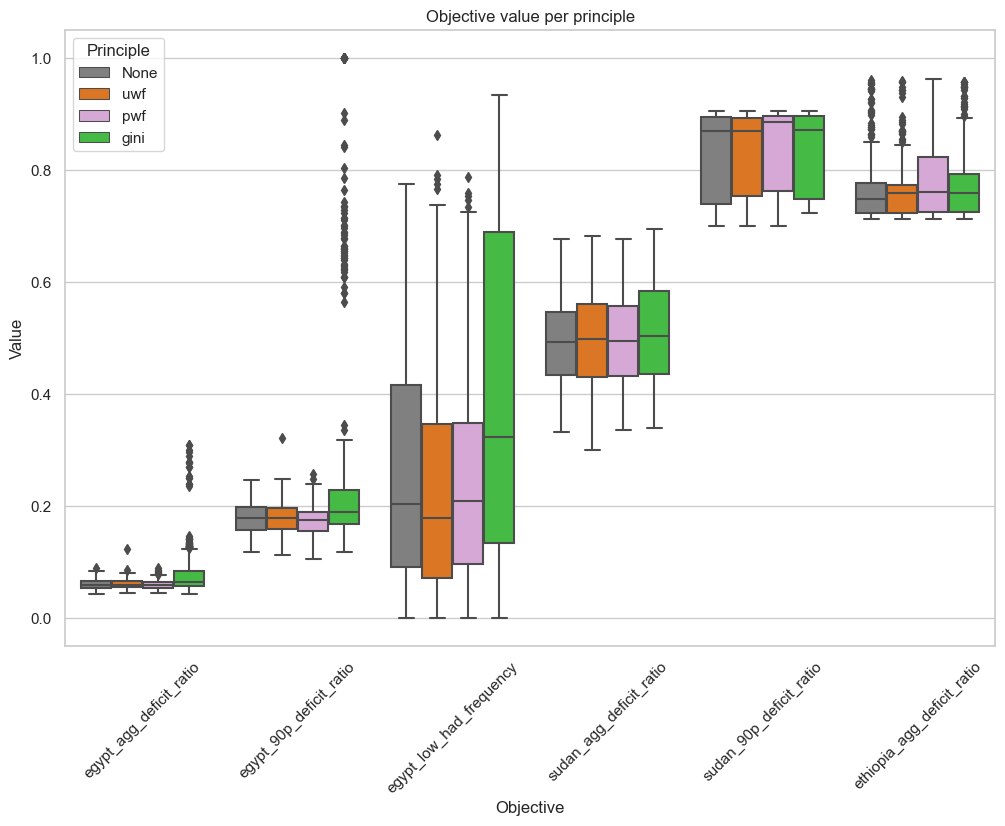

In [11]:
# Objectives of interest
objectives_of_interest = ['egypt_agg_deficit_ratio', 'egypt_90p_deficit_ratio', 'egypt_low_had_frequency', 'sudan_agg_deficit_ratio', 'sudan_90p_deficit_ratio', 'ethiopia_agg_deficit_ratio']

# Melt the DataFrame to have 'Principle', 'Index', and 'Objective' columns
melted_df = pd.melt(df_experiments.reset_index(), id_vars=['Principle', 'Index'], value_vars=objectives_of_interest, var_name='Objective', value_name='Value')

# Create a boxplot using seaborn with 'Objective' on the x-axis, 'Experiment' as individual boxes, and 'Principle' as hue
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Set the palette to use principle colors
sns.boxplot(x='Objective', y='Value', hue='Principle', data=melted_df, palette=principle_colors)

plt.title('Objective value per principle')
plt.xlabel('Objective')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()


##

# 2. Creating prcinciple results

## 2.1 Normalization

### 2.1.1 Normalization with MinMaxScalar

## 2.2 Formulating the SWFs

### 2.2.1 The Utilitarian Welfare Function

In [12]:

def calculate_utilitarian_welfare(refSet, columns):
    """
    Calculates the utilitarian welfare for each policy in the DataFrame.

    Args:
        refSet (pandas.DataFrame): Input DataFrame containing policy data.
        columns (list): List of column names to consider for calculating the utilitarian welfare.

    Returns:
        pandas.DataFrame: A new DataFrame with the utilitarian welfare scores for each policy.
    """
    # Create a copy of the input DataFrame to avoid modifying the original data
    df_uwf = refSet.copy()
    
    # Calculate the utilitarian welfare and add it as a new column to the new DataFrame
    uwf = df_uwf[columns].apply(lambda row: 1 - row, axis=1).sum(axis=1)
    df_uwf['utilitarian_welfare'] = uwf
    
    return df_uwf

### 2.2.2 The Prioritarian Welfare Function

In [13]:
def compute_pairwise_differences(objectives):
    """Computes the signed pairwise differences prioritizing lower objectives."""
    pairwise_differences = np.zeros((len(objectives), len(objectives)))
    for i in range(len(objectives)):
        for j in range(len(objectives)):
            pairwise_differences[i, j] = objectives[j] - objectives[i]  # Inversion for prioritization
    return pairwise_differences

def compute_gamma(objectives):
    """Computes gamma values for each objective."""
    pairwise_differences = compute_pairwise_differences(objectives)
    gamma_raw = np.sum(pairwise_differences, axis=1) - np.diagonal(pairwise_differences)
    gamma_raw /= (len(objectives) - 1)
    gamma_per_objective = (gamma_raw - np.min(gamma_raw)) / (np.max(gamma_raw) - np.min(gamma_raw))
    gamma_per_objective /= np.sum(gamma_per_objective)
    return gamma_per_objective

def compute_pwf_pairwise(objectives):
    """Computes PWF values for each objective based on gamma and returns the total sum."""
    gamma_per_objective = compute_gamma(objectives)
    pwf_results = []
    for idx, obj in enumerate(objectives):
        if gamma_per_objective[idx] != 1:
            if obj >= 0:
                pwf_results.append((obj ** (1 - gamma_per_objective[idx])) / (1 - gamma_per_objective[idx]))
            else:
                pwf_results.append((abs(obj) ** (1 - gamma_per_objective[idx])) / (1 - gamma_per_objective[idx]))
        else:
            pwf_results.append(np.log(abs(obj)))
    
    total_pwf = sum(pwf_results)
    return pwf_results, total_pwf

def compute_pwf(objectives, gamma):
    """Computes PWF values for each objective based on preset gamma and returns the total sum."""
    pwf_results = []
    for obj in objectives:
        if (1 - obj) == 0:
            pwf_results.append(0)
        elif obj > 0:
            pwf_results.append(( (1 - obj) ** (1 - gamma)) / (1 - gamma))
        else:
            pwf_results.append(( (1 + obj) ** (1 - gamma)) / (1 - gamma))
    
    total_pwf = sum(pwf_results)
    return pwf_results, total_pwf


In [14]:
def calculate_prioritarian_welfare_pairwise(refset, columns):
    """
    Calculate Prioritarian Welfare for a solution set in a DataFrame by computing gamma and PWF for each set of objectives.

    Args:
        refset (pandas.DataFrame): Input DataFrame containing solution sets.
        columns (list): List of column names representing objectives.

    Returns:
        pandas.DataFrame: A new DataFrame with computed gamma and PWF values for each solution set.
    """
    
    # Create a new DataFrame as a copy of the input 'refset'
    df_pwf = refset.copy()
    
    # Calculate gamma values for each solution set and store them in a new 'gamma_values' column
    df_pwf['gamma_values'] = df_pwf[columns].apply(compute_gamma, axis=1)
    
    # Calculate PWF values for each solution set and store them in 'pwf_values' and 'total_pwf' columns
    df_pwf[['pwf_values', 'total_pwf']] = df_pwf[columns].apply(compute_pwf_pairwise, axis=1).apply(pd.Series)
    
    return df_pwf

In [15]:
def calculate_prioritarian_welfare(refset, columns, gamma):
    """
    Calculate Prioritarian Welfare for a solution set in a DataFrame by computing gamma and PWF for each set of objectives.

    Args:
        refset (pandas.DataFrame): Input DataFrame containing solution sets.
        columns (list): List of column names representing objectives.

    Returns:
        pandas.DataFrame: A new DataFrame with computed gamma and PWF values for each solution set.
    """
    
    # Create a new DataFrame as a copy of the input 'refset'
    df_pwf = refset.copy()
    
    # Calculate PWF values for each solution set and store them in 'pwf_values' and 'total_pwf' columns
    df_pwf[['pwf_values', 'total_pwf']] = df_pwf[columns].apply(lambda row: compute_pwf(row, gamma), axis=1).apply(pd.Series)
    
    return df_pwf

### 2.2.3 The Egalitarian Welfare Function

In [16]:
def calculate_gini_index(refSet, columns):
    """
    Calculates the Gini index of each policy in a DataFrame and adds it as a new column.

    Args:
        refSet (pandas.DataFrame): Input DataFrame containing policy data.
        columns (list): List of column names to consider for calculating the Gini index.

    Returns:
        pandas.DataFrame: DataFrame with the added Gini index column.
    """

    df_gini = refSet.copy()

    mean_x = df_gini[columns].mean(axis=1)
    denominator = 2 * mean_x * len(columns)**2

    numerator = df_gini[columns].sub(df_gini[columns].mean(axis=1), axis='rows').abs().sum(axis=1)


    gini_index = numerator / denominator
    df_gini['gini_index'] = gini_index

    return df_gini

## 2.3 Creating the A Posteriori experiment results for all principles 

In [17]:
df_experiments

egypt_agg_deficit_ratio  egypt_90p_deficit_ratio  \
Principle Index                                                     
None      0                     0.059863                 0.189728   
          1                     0.062170                 0.188981   
          2                     0.064460                 0.198946   
          3                     0.061862                 0.189675   
          4                     0.064488                 0.198994   
...                                  ...                      ...   
gini      333                   0.058888                 0.185044   
          334                   0.269800                 1.000000   
          335                   0.048625                 0.152609   
          336                   0.099155                 0.162350   
          337                   0.056078                 0.176157   

                 egypt_low_had_frequency  sudan_agg_deficit_ratio  \
Principle Index                                                     
None      0                     0.137500                 0.447351   
          1                     0.183333                 0.464333   
          2                     0.020833                 0.602078   
          3                     0.383333                 0.442585   
          4                     0.037500                 0.509928   
...                                  ...                      ...   
gini      333                   0.262500                 0.383202   
          334                   0.900000                 0.434169   
          335                   0.195833                 0.686921   
          336                   0.700000                 0.645428   
          337                   0.095833                 0.493905   

                 sudan_90p_deficit_ratio  ethiopia_agg_deficit_ratio  \
Principle Index                                                        
None      0                     0.887193                    0.775475   
          1                     0.740000                    0.749739   
          2                     0.897248                    0.721120   
          3                     0.754036                    0.746443   
          4                     0.732470                    0.742275   
...                                  ...                         ...   
gini      333                   0.875075                    0.849522   
          334                   0.892256                    0.820905   
          335                   0.903032                    0.757236   
          336                   0.905318                    0.768033   
          337                   0.886140                    0.813899   

                 principle_result  
Principle Index                    
None      0                   NaN  
          1                   NaN  
          2                   NaN  
          3                   NaN  
          4                   NaN  
...                           ...  
gini      333            0.605042  
          334            0.802344  
          335            0.600559  
          336            0.700105  
          337            0.562370  

[1002 rows x 7 columns]

In [18]:
# Define columns to consider for calculating utilitarian welfare
objectives_narrow = ['egypt_agg_deficit_ratio', 'egypt_90p_deficit_ratio', 'egypt_low_had_frequency', 'sudan_agg_deficit_ratio', 'sudan_90p_deficit_ratio', 'ethiopia_agg_deficit_ratio']
directions_narrow = {'egypt_agg_deficit_ratio': 'min', 'egypt_90p_deficit_ratio': 'min', 'egypt_low_had_frequency': 'min', 'sudan_agg_deficit_ratio': 'min', 'sudan_90p_deficit_ratio': 'min', 'ethiopia_agg_deficit_ratio': 'min',}

In [19]:
prio_dfs = {}

# Assuming 'grouped' is your grouped DataFrame and 'objectives_narrow' contains the column names you want to normalize
for principle, subset in df_experiments.groupby(level='Principle', sort=False):
    # Extract the subset of columns you want to use for swf calculations
    subset_to_analyze = subset.copy()[objectives_narrow]
    # Use the principle as the key in the dictionary
    prio_dfs[principle] = subset_to_analyze.droplevel(level='Principle')

In [20]:
# Access the normalized subsets using principle names (e.g., 'None', 'uwf', 'pwf', 'gini')
prio_none = prio_dfs['None']
prio_uwf = prio_dfs['uwf']
prio_pwf = prio_dfs['pwf']
prio_gini = prio_dfs['gini']

In [21]:
# Define a dictionary to store utilitarian welfare DataFrames for each subset
utilitarian_welfare_results = {}

# Calculate utilitarian welfare for each normalized subset
swf_dfs = {}
for principle, subset in prio_dfs.items():
    swf_dfs[principle] = calculate_utilitarian_welfare(subset, objectives_narrow)
    swf_dfs[principle] = calculate_prioritarian_welfare(swf_dfs[principle], objectives_narrow, gamma=3)
    swf_dfs[principle] = calculate_gini_index(swf_dfs[principle], objectives_narrow)

In [22]:
# Concatenate all the dataframes in swf_dfs into one dataframe with a multi-level index
df_swfs = pd.concat(swf_dfs, names=["Principle", "Index"])

df_swfs

egypt_agg_deficit_ratio  egypt_90p_deficit_ratio  \
Principle Index                                                     
None      0                     0.059863                 0.189728   
          1                     0.062170                 0.188981   
          2                     0.064460                 0.198946   
          3                     0.061862                 0.189675   
          4                     0.064488                 0.198994   
...                                  ...                      ...   
gini      333                   0.058888                 0.185044   
          334                   0.269800                 1.000000   
          335                   0.048625                 0.152609   
          336                   0.099155                 0.162350   
          337                   0.056078                 0.176157   

                 egypt_low_had_frequency  sudan_agg_deficit_ratio  \
Principle Index                                                     
None      0                     0.137500                 0.447351   
          1                     0.183333                 0.464333   
          2                     0.020833                 0.602078   
          3                     0.383333                 0.442585   
          4                     0.037500                 0.509928   
...                                  ...                      ...   
gini      333                   0.262500                 0.383202   
          334                   0.900000                 0.434169   
          335                   0.195833                 0.686921   
          336                   0.700000                 0.645428   
          337                   0.095833                 0.493905   

                 sudan_90p_deficit_ratio  ethiopia_agg_deficit_ratio  \
Principle Index                                                        
None      0                     0.887193                    0.775475   
          1                     0.740000                    0.749739   
          2                     0.897248                    0.721120   
          3                     0.754036                    0.746443   
          4                     0.732470                    0.742275   
...                                  ...                         ...   
gini      333                   0.875075                    0.849522   
          334                   0.892256                    0.820905   
          335                   0.903032                    0.757236   
          336                   0.905318                    0.768033   
          337                   0.886140                    0.813899   

                 utilitarian_welfare  \
Principle Index                        
None      0                 3.502890   
          1                 3.611443   
          2                 3.495314   
          3                 3.422065   
          4                 3.714346   
...                              ...   
gini      333               3.385769   
          334               1.682869   
          335               3.255744   
          336               2.719717   
          337               3.477988   

                                                        pwf_values  \
Principle Index                                                      
None      0      [-0.5657024595921845, -0.7615667389048187, -0....   
          1      [-0.568489162880979, -0.7601658973858617, -0.7...   
          2      [-0.5712754061150576, -0.7791958335116052, -0....   
          3      [-0.5681156353921976, -0.7614686619294422, -1....   
          4      [-0.5713094993410573, -0.7792880998621553, -0....   
...                                                            ...   
gini      333    [-0.5645300101026696, -0.752838595323135, -0.9...   
          334    [-0.9377495707200256, 0, -50.00000000000002, -...   
          335    [-0.5524168726157689, -0.696308779094049, -0.7

Check if this went well by comparing df_none with the first subset

In [23]:
df_swfs_exps = pd.merge(df_experiments, df_swfs[['utilitarian_welfare', 'total_pwf', 'gini_index']], on=['Principle', 'Index'])
df_swfs_exps

egypt_agg_deficit_ratio  egypt_90p_deficit_ratio  \
Principle Index                                                     
None      0                     0.059863                 0.189728   
          1                     0.062170                 0.188981   
          2                     0.064460                 0.198946   
          3                     0.061862                 0.189675   
          4                     0.064488                 0.198994   
...                                  ...                      ...   
gini      333                   0.058888                 0.185044   
          334                   0.269800                 1.000000   
          335                   0.048625                 0.152609   
          336                   0.099155                 0.162350   
          337                   0.056078                 0.176157   

                 egypt_low_had_frequency  sudan_agg_deficit_ratio  \
Principle Index                                                     
None      0                     0.137500                 0.447351   
          1                     0.183333                 0.464333   
          2                     0.020833                 0.602078   
          3                     0.383333                 0.442585   
          4                     0.037500                 0.509928   
...                                  ...                      ...   
gini      333                   0.262500                 0.383202   
          334                   0.900000                 0.434169   
          335                   0.195833                 0.686921   
          336                   0.700000                 0.645428   
          337                   0.095833                 0.493905   

                 sudan_90p_deficit_ratio  ethiopia_agg_deficit_ratio  \
Principle Index                                                        
None      0                     0.887193                    0.775475   
          1                     0.740000                    0.749739   
          2                     0.897248                    0.721120   
          3                     0.754036                    0.746443   
          4                     0.732470                    0.742275   
...                                  ...                         ...   
gini      333                   0.875075                    0.849522   
          334                   0.892256                    0.820905   
          335                   0.903032                    0.757236   
          336                   0.905318                    0.768033   
          337                   0.886140                    0.813899   

                 principle_result  utilitarian_welfare   total_pwf  gini_index  
Principle Index                                                                 
None      0                   NaN             3.502890  -52.845936    0.057497  
          1                   NaN             3.611443  -19.200643    0.053016  
          2                   NaN             3.495314  -58.815904    0.064419  
          3                   NaN             3.422065  -20.295470    0.042288  
          4                   NaN             3.714346  -18.485686    0.061386  
...                           ...                  ...         ...         ...  
gini      333            0.605042             3.385769  -57.670601    0.054394  
          334            0.802344             1.682869 -111.158951    0.028378  
          335            0.600559             3.255744  -68.783051    0.059218  
          336            0.700105             2.719717  -75.928109    0.042269  
          337            0.562370             3.477988  -56.866261    0.061653  

[1002 rows x 10 columns]

## 2.4 Verification

Since we want to be consequent in our evaluation. The following cells are to verify if the values from the a priori optmization find the same values as the posteriori optimization. We can check this by comparing the experiment principle_result objective values with the corresponding posteriori column values for the principle of that experiment. In other words, If optimised for uwf compare with posteriori uwf column.

In [24]:
# Flag to indicate whether we have reached the second principle index value
second_principle_flag = False

# List to store the indices where mismatches are found
mismatch_indices = []

# Iterate over unique values in the 'Principle' level
for principle in df_swfs_exps.index.get_level_values('Principle').unique():
    # Get the subset of the DataFrame for the current principle
    subset = df_swfs_exps.loc[principle]
    # Counter for columns to consider from the back
    column_counter = 4  # Start from the third column from the back
    # Iterate over the rows in the subset
    for idx in range(len(subset.index)):  # Iterate till the third column from the back
        # Check if we have reached the second principle index value
        if not second_principle_flag:
            continue
        # Get the values for principle_result and the corresponding column
        principle_result_value = subset.iloc[idx]['principle_result']
        corresponding_column_value = subset.iloc[idx, -column_counter]  # Column from the back
        # Compare the values
        if principle_result_value != corresponding_column_value:
            mismatch_indices.append((principle, subset.index[idx]))  # Store the mismatch indices
        # Increment the column counter for the next iteration
    column_counter -= 1  # Move to the next column from the back
    second_principle_flag = True

# Print mismatches found
if len(mismatch_indices) > 0:
    print("Mismatches found:")
    for principle, idx in mismatch_indices:
        print(f"Principle: {principle}, Index: {idx}")
else:
    print("No mismatches found.")

No mismatches found.


# 3. Visualization of results

## 3.1 Needed functions 

In [25]:
def get_best_solutions(dataframe, objective_directions):
    """
    Get the index of the best performing solution for each objective based on the specified objective directions.

    Args:
        dataframe (pd.DataFrame): The input DataFrame containing the objective values.
        objective_directions (dict): A dictionary mapping each objective column name to its direction ('min' or 'max').

    Returns:
        dict: A dictionary mapping each objective column name to the index of the best performing solution.

    """
    if not set(objective_directions.values()).issubset({'min', 'max'}):
        raise ValueError("Invalid objective direction. Must be 'min' or 'max'.")

    best_solutions = {}

    for column, direction in objective_directions.items():
        if direction == 'max':
            best_index = dataframe[column].idxmax()
        elif direction == 'min':
            best_index = dataframe[column].idxmin()

        best_solutions[column] = best_index

    return best_solutions

In [26]:
def create_global_variables(best_obj_indices, policies):
    """
    Create individual variables dynamically using a loop.

    Parameters:
        best_obj_indices (dict): A dictionary containing the objective names as keys and their
                                 corresponding best value indices as values.
        policies (list): A list of the initial names for the created global variables.

    Returns:
        tuple: A tuple containing a list of the names of the created global variables and a
               dictionary mapping objective indices to variable names.
    """
    created_global_variable_names = policies
    created_global_variables = {}
    unique_solutions = []

    # Iterate over the objective indices and initial variable names
    for (obj_name, obj_indeces), var_name in zip(best_obj_indices.items(), created_global_variable_names):
        print(var_name)
        print(obj_indeces)
        # Ensure obj_indeces is a list
        if not isinstance(obj_indeces, (list, tuple)):
            obj_indeces = [obj_indeces]

        overplotted = False
        # Iterate over the indices for the current objective
        for obj_index in obj_indeces:
            print(obj_index)
            # Check if the obj_index is already in unique_solutions
            if obj_index in unique_solutions and not overplotted:
                # Replace the corresponding list item with "Overplotted" + the original string
                index = created_global_variable_names.index(var_name)
                print("ov:", var_name)
                created_global_variable_names[index] = "*Overplotted " + var_name
                overplotted = True
            else:
                # Add obj_index to unique_solutions for future checks
                unique_solutions.append(obj_index)
                created_global_variables[obj_index] = var_name

    return created_global_variable_names, created_global_variables


In [27]:
# def create_global_variables(best_obj_indices, policies):
#     """
#     Create individual variables dynamically using a loop.

#     Parameters:
#         best_obj_indices (dict): A dictionary containing the objective names as keys and their
#                                  corresponding best value indices as values.
#         policies (DataFrame): The DataFrame containing the data.

#     Returns:
#         Tuple[list, list]: A tuple containing a list of the names of the created global variables
#                            and a list of the created global variables.
#     """
#     created_global_variable_names = []
#     created_global_variables = {}

#     for obj_name, obj_indices in best_obj_indices.items():
#         if not isinstance(obj_indices, (list, tuple)):
#             obj_indices = [obj_indices]  # Convert to list if it's a single index

#         # Create a unique global variable name based on the value
#         global_variable_name = f"Best {obj_name}"

#         # Check if the variable name already exists, and if so, append "overplotted_" to it
#         while global_variable_name in created_global_variable_names:
#             global_variable_name = "Overplotted " + global_variable_name

#         globals()[global_variable_name] = best_obj_indices[obj_name]
#         created_global_variable_names.append(global_variable_name)
#         created_global_variables.append(globals()[global_variable_name])

#     return created_global_variable_names, created_global_variables

For merged best solution names

In [28]:
# def create_global_variables(best_obj_indices, policies):
#     """
#     Create individual variables dynamically using a loop.

#     Parameters:
#         best_obj_indices (dict): A dictionary containing the objective names as keys and their
#                                  corresponding best value indices as values.
#         policies (DataFrame): The DataFrame containing the data.

#     Returns:
#         list: A list of the names of the created global variables.
#     """
#     created_global_variable_names = []
#     created_global_variables = []
#     merged_keys_dict = {}

#     for obj_name, obj_indices in best_obj_indices.items():
#         if not isinstance(obj_indices, (list, tuple)):
#             obj_indices = [obj_indices]  # Convert to list if it's a single index
#         value = tuple(obj_indices)
#         if value in merged_keys_dict:
#             merged_keys_dict[value].append(obj_name)
#         else:
#             merged_keys_dict[value] = [obj_name]

#     for value, obj_names in merged_keys_dict.items():
#         # Check if the indices are unique for the merged keys
#         if len(obj_names) == 1:
#             obj_name = obj_names[0]
#             global_variable_name = f"best_{obj_name}"
#             globals()[global_variable_name] = best_obj_indices[obj_name]
#             created_global_variable_names.append(global_variable_name)
#             created_global_variables.append(globals()[global_variable_name])
#         else:
#             # If the indices are not unique, merge the key strings
#             merged_key_string = "_".join(obj_names)
#             global_variable_name = f"best_{merged_key_string}"
#             globals()[global_variable_name] = value
#             created_global_variable_names.append(global_variable_name)
#             created_global_variables.append(globals()[global_variable_name])

#     return created_global_variable_names, created_global_variables

## 3.2 A Posteriori results

In [29]:
df_swfs_None = df_swfs_exps.xs(key='None', level='Principle').drop(columns='principle_result')
df_swfs_None

egypt_agg_deficit_ratio  egypt_90p_deficit_ratio  \
Index                                                     
0                     0.059863                 0.189728   
1                     0.062170                 0.188981   
2                     0.064460                 0.198946   
3                     0.061862                 0.189675   
4                     0.064488                 0.198994   
...                        ...                      ...   
202                   0.055046                 0.165804   
203                   0.056846                 0.180048   
204                   0.049067                 0.150446   
205                   0.044377                 0.117045   
206                   0.047062                 0.128916   

       egypt_low_had_frequency  sudan_agg_deficit_ratio  \
Index                                                     
0                     0.137500                 0.447351   
1                     0.183333                 0.464333   
2                     0.020833                 0.602078   
3                     0.383333                 0.442585   
4                     0.037500                 0.509928   
...                        ...                      ...   
202                   0.591667                 0.536966   
203                   0.350000                 0.528810   
204                   0.208333                 0.526988   
205                   0.187500                 0.541714   
206                   0.266667                 0.536243   

       sudan_90p_deficit_ratio  ethiopia_agg_deficit_ratio  \
Index                                                        
0                     0.887193                    0.775475   
1                     0.740000                    0.749739   
2                     0.897248                    0.721120   
3                     0.754036                    0.746443   
4                     0.732470                    0.742275   
...                        ...                         ...   
202                   0.732470                    0.739655   
203                   0.732470                    0.748325   
204                   0.892661                    0.836296   
205                   0.905381                    0.944782   
206                   0.893955                    0.941379   

       utilitarian_welfare   total_pwf  gini_index  
Index                                               
0                 3.502890  -52.845936    0.057497  
1                 3.611443  -19.200643    0.053016  
2                 3.495314  -58.815904    0.064419  
3                 3.422065  -20.295470    0.042288  
4                 3.714346  -18.485686    0.061386  
...                    ...         ...         ...  
202               3.178393  -20.972048    0.042510  
203               3.403501  -19.621068    0.045661  
204               3.336209  -66.332207    0.057815  
205               3.259201 -224.159988    0.062116  
206               3.185778 -194.425969    0.057119  

[207 rows x 9 columns]

In [30]:
best_solutions_None_narrow = get_best_solutions(df_swfs_None[objectives_narrow], directions_narrow)
print(best_solutions_None_narrow)

{'egypt_agg_deficit_ratio': 178, 'egypt_90p_deficit_ratio': 205, 'egypt_low_had_frequency': 99, 'sudan_agg_deficit_ratio': 120, 'sudan_90p_deficit_ratio': 120, 'ethiopia_agg_deficit_ratio': 59}


In [31]:
policies_narrow = ["Best Egypt Irr", "Best Egypt 90$^{th}$", "Best Egypt HAD", "Best Sudan Irr", "Best Sudan 90$^{th}$", "Best Ethiopia Hydro"]
created_vars_names_None_narrow, created_vars_None_narrow = create_global_variables(best_solutions_None_narrow, policies_narrow)

Best Egypt Irr
Best Egypt 90$^{th}$
Best Egypt HAD
Best Sudan Irr
Best Sudan 90$^{th}$
ov: Best Sudan 90$^{th}$
Best Ethiopia Hydro


In [32]:
### Now color by a categorical variable that isnt one of the axes
df_swfs_None["Category_narrow"] = 'other'
for solution_index, policy in created_vars_None_narrow.items():
    print(solution_index)
    print(policy)
    df_swfs_None.loc[solution_index, "Category_narrow"] = policy
df_swfs_None

178
Best Egypt Irr
205
Best Egypt 90$^{th}$
99
Best Egypt HAD
120
Best Sudan Irr
59
Best Ethiopia Hydro


egypt_agg_deficit_ratio  egypt_90p_deficit_ratio  \
Index                                                     
0                     0.059863                 0.189728   
1                     0.062170                 0.188981   
2                     0.064460                 0.198946   
3                     0.061862                 0.189675   
4                     0.064488                 0.198994   
...                        ...                      ...   
202                   0.055046                 0.165804   
203                   0.056846                 0.180048   
204                   0.049067                 0.150446   
205                   0.044377                 0.117045   
206                   0.047062                 0.128916   

       egypt_low_had_frequency  sudan_agg_deficit_ratio  \
Index                                                     
0                     0.137500                 0.447351   
1                     0.183333                 0.464333   
2                     0.020833                 0.602078   
3                     0.383333                 0.442585   
4                     0.037500                 0.509928   
...                        ...                      ...   
202                   0.591667                 0.536966   
203                   0.350000                 0.528810   
204                   0.208333                 0.526988   
205                   0.187500                 0.541714   
206                   0.266667                 0.536243   

       sudan_90p_deficit_ratio  ethiopia_agg_deficit_ratio  \
Index                                                        
0                     0.887193                    0.775475   
1                     0.740000                    0.749739   
2                     0.897248                    0.721120   
3                     0.754036                    0.746443   
4                     0.732470                    0.742275   
...                        ...                         ...   
202                   0.732470                    0.739655   
203                   0.732470                    0.748325   
204                   0.892661                    0.836296   
205                   0.905381                    0.944782   
206                   0.893955                    0.941379   

       utilitarian_welfare   total_pwf  gini_index       Category_narrow  
Index                                                                     
0                 3.502890  -52.845936    0.057497                 other  
1                 3.611443  -19.200643    0.053016                 other  
2                 3.495314  -58.815904    0.064419                 other  
3                 3.422065  -20.295470    0.042288                 other  
4                 3.714346  -18.485686    0.061386                 other  
...                    ...         ...         ...                   ...  
202               3.178393  -20.972048    0.042510                 other  
203               3.403501  -19.621068    0.045661                 other  
204               3.336209  -66.332207    0.057815                 other  
205               3.259201 -224.159988    0.062116  Best Egypt 90$^{th}$  
206               3.185778 -194.425969    0.057119                 other  

[207 rows x 10 columns]

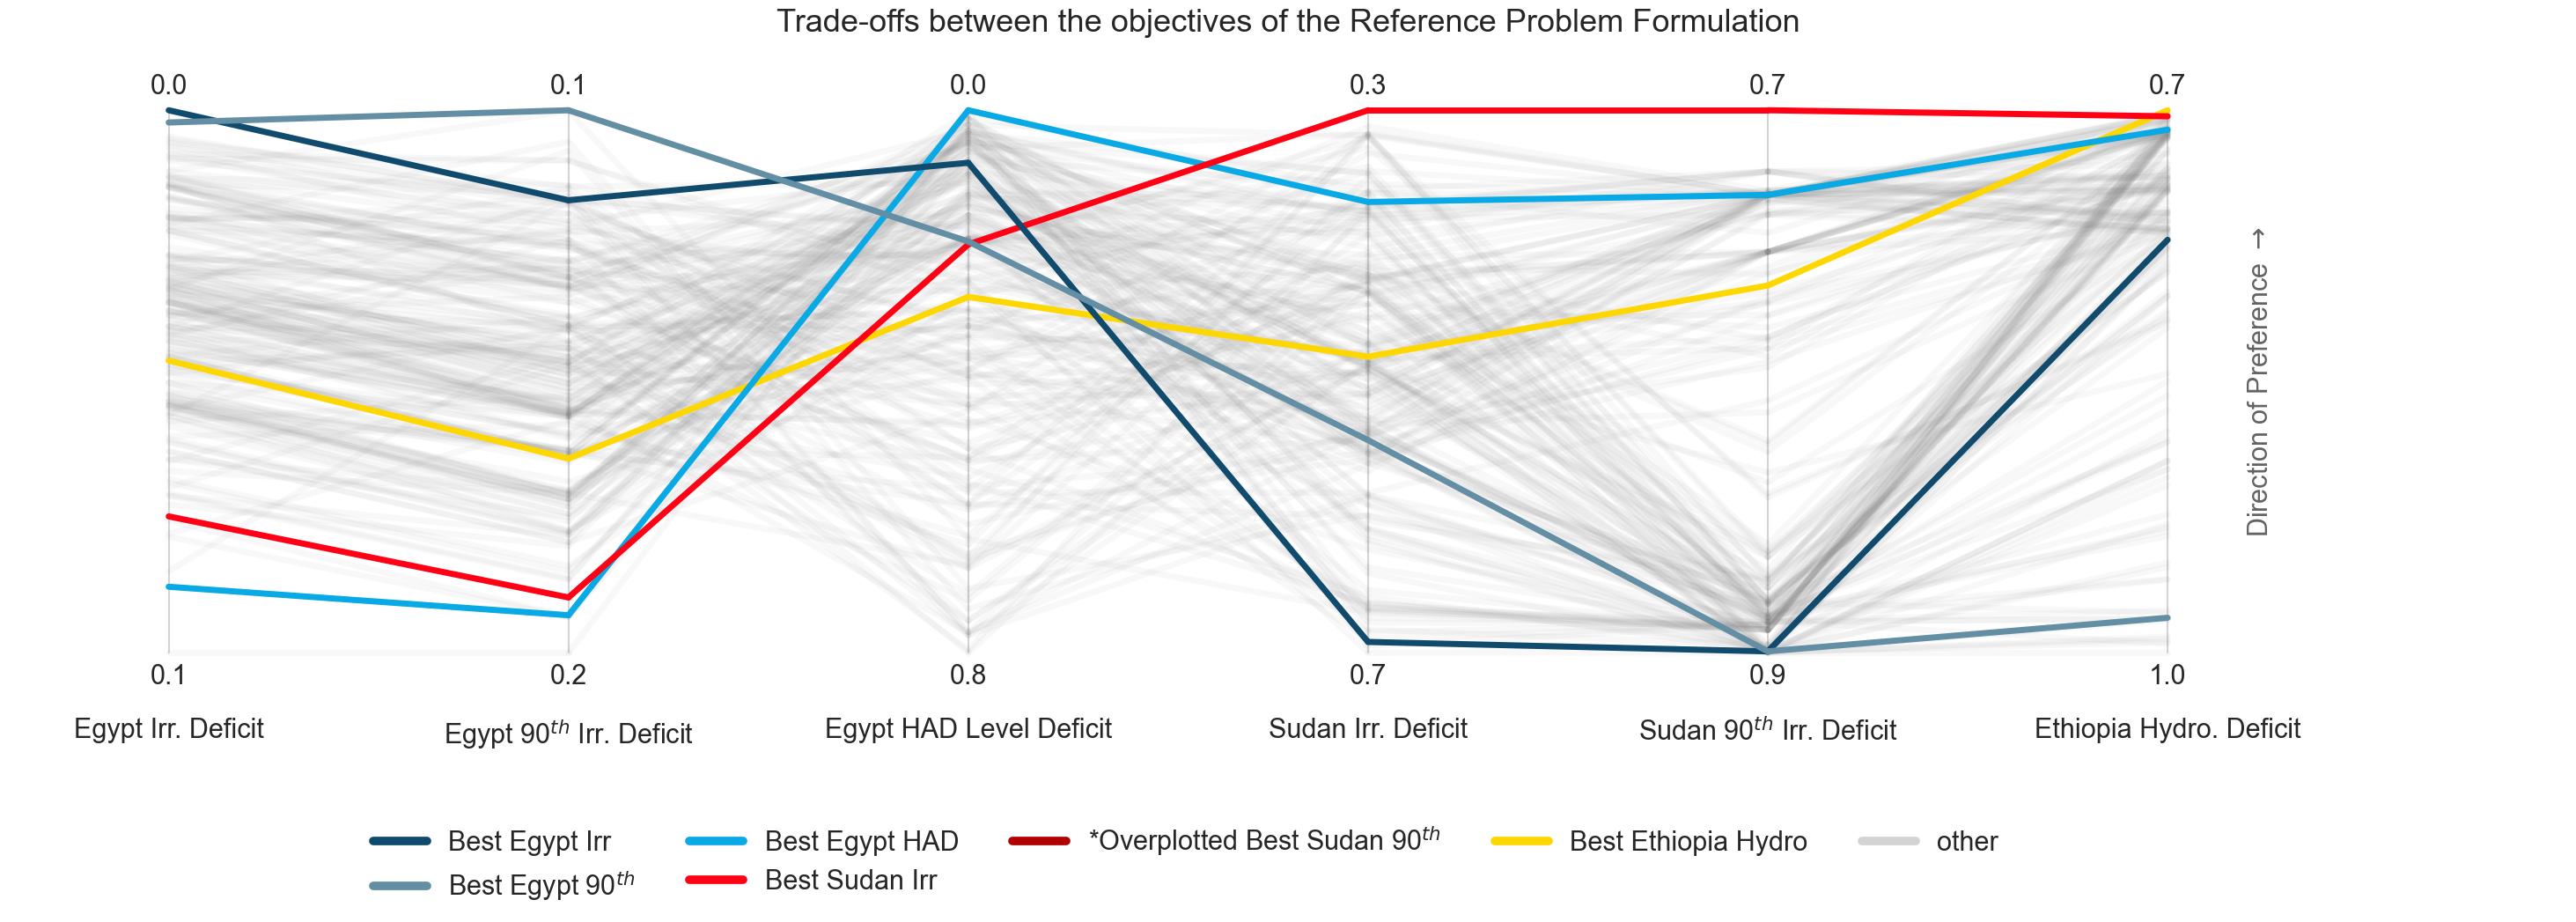

In [33]:
fig, ax = plt.subplots(figsize=(37.5, 12))

custom_parallel_coordinates(
    ax,
    df_swfs_None,
    columns_axes=objectives_narrow, 
    axis_labels=[
            "Egypt Irr. Deficit",
            "Egypt 90$^{th}$ Irr. Deficit",
            "Egypt HAD Level Deficit",
            "Sudan Irr. Deficit",
            "Sudan 90$^{th}$ Irr. Deficit",
            "Ethiopia Hydro. Deficit",
    ],
    ideal_direction='top',
    directions=directions_narrow,
    color_by_categorical='Category_narrow',
    color_categories=created_vars_names_None_narrow,
    brushing_dict = {'Category_narrow': (['other'], '!=')},
    title='Trade-offs between the objectives of the Reference Problem Formulation',)
plt.show()

In [34]:
objectives_broad = ['egypt_agg_deficit_ratio', 'egypt_90p_deficit_ratio', 'egypt_low_had_frequency', 'sudan_agg_deficit_ratio', 'sudan_90p_deficit_ratio', 'ethiopia_agg_deficit_ratio', 'utilitarian_welfare', 'total_pwf', 'gini_index']
# Create a copy of directions_narrow
directions_broad = directions_narrow.copy()

# Update directions_broad with additional key-value pairs
directions_broad.update({'utilitarian_welfare': 'max', 'total_pwf': 'max', 'gini_index': 'min'})


In [35]:
print(directions_broad)

{'egypt_agg_deficit_ratio': 'min', 'egypt_90p_deficit_ratio': 'min', 'egypt_low_had_frequency': 'min', 'sudan_agg_deficit_ratio': 'min', 'sudan_90p_deficit_ratio': 'min', 'ethiopia_agg_deficit_ratio': 'min', 'utilitarian_welfare': 'max', 'total_pwf': 'max', 'gini_index': 'min'}


In [36]:
best_solutions_swfs_None_broad = get_best_solutions(df_swfs_None[objectives_broad], directions_broad)
policies_broad = ["Best Egypt Irr", "Best Egypt 90$^{th}$", "Best Egypt HAD", "Best Sudan Irr", "Best Sudan 90$^{th}$", "Best Ethiopia Hydro", "Best Utilitarian", "Best Prioritarian", "Best Egalitarian"]
created_vars_names_swfs_None_broad, created_vars_swfs_None_broad = create_global_variables(best_solutions_swfs_None_broad, policies_broad)
print(best_solutions_swfs_None_broad)

Best Egypt Irr
Best Egypt 90$^{th}$
Best Egypt HAD
Best Sudan Irr
Best Sudan 90$^{th}$
ov: Best Sudan 90$^{th}$
Best Ethiopia Hydro
Best Utilitarian
Best Prioritarian
ov: Best Prioritarian
Best Egalitarian
{'egypt_agg_deficit_ratio': 178, 'egypt_90p_deficit_ratio': 205, 'egypt_low_had_frequency': 99, 'sudan_agg_deficit_ratio': 120, 'sudan_90p_deficit_ratio': 120, 'ethiopia_agg_deficit_ratio': 59, 'utilitarian_welfare': 16, 'total_pwf': 120, 'gini_index': 175}


In [37]:
### Now color by a categorical variable that isnt one of the axes
df_swfs_None["Category_broad"] = 'other'
for solution_index, policy in created_vars_swfs_None_broad.items():
    df_swfs_None.loc[solution_index, "Category_broad"] = policy
df_swfs_None

egypt_agg_deficit_ratio  egypt_90p_deficit_ratio  \
Index                                                     
0                     0.059863                 0.189728   
1                     0.062170                 0.188981   
2                     0.064460                 0.198946   
3                     0.061862                 0.189675   
4                     0.064488                 0.198994   
...                        ...                      ...   
202                   0.055046                 0.165804   
203                   0.056846                 0.180048   
204                   0.049067                 0.150446   
205                   0.044377                 0.117045   
206                   0.047062                 0.128916   

       egypt_low_had_frequency  sudan_agg_deficit_ratio  \
Index                                                     
0                     0.137500                 0.447351   
1                     0.183333                 0.464333   
2                     0.020833                 0.602078   
3                     0.383333                 0.442585   
4                     0.037500                 0.509928   
...                        ...                      ...   
202                   0.591667                 0.536966   
203                   0.350000                 0.528810   
204                   0.208333                 0.526988   
205                   0.187500                 0.541714   
206                   0.266667                 0.536243   

       sudan_90p_deficit_ratio  ethiopia_agg_deficit_ratio  \
Index                                                        
0                     0.887193                    0.775475   
1                     0.740000                    0.749739   
2                     0.897248                    0.721120   
3                     0.754036                    0.746443   
4                     0.732470                    0.742275   
...                        ...                         ...   
202                   0.732470                    0.739655   
203                   0.732470                    0.748325   
204                   0.892661                    0.836296   
205                   0.905381                    0.944782   
206                   0.893955                    0.941379   

       utilitarian_welfare   total_pwf  gini_index       Category_narrow  \
Index                                                                      
0                 3.502890  -52.845936    0.057497                 other   
1                 3.611443  -19.200643    0.053016                 other   
2                 3.495314  -58.815904    0.064419                 other   
3                 3.422065  -20.295470    0.042288                 other   
4                 3.714346  -18.485686    0.061386                 other   
...                    ...         ...         ...                   ...   
202               3.178393  -20.972048    0.042510                 other   
203               3.403501  -19.621068    0.045661                 other   
204               3.336209  -66.332207    0.057815                 other   
205               3.259201 -224.159988    0.062116  Best Egypt 90$^{th}$   
206               3.185778 -194.425969    0.057119                 other   

             Category_broad  
Index                        
0                     other  
1                     other  
2                     other  
3                     other  
4                     other  
...                     ...  
202                   other  
203                   other  
204                   other  
205    Best Egypt 90$^{th}$  
206                   other  

[207 rows x 11 columns]

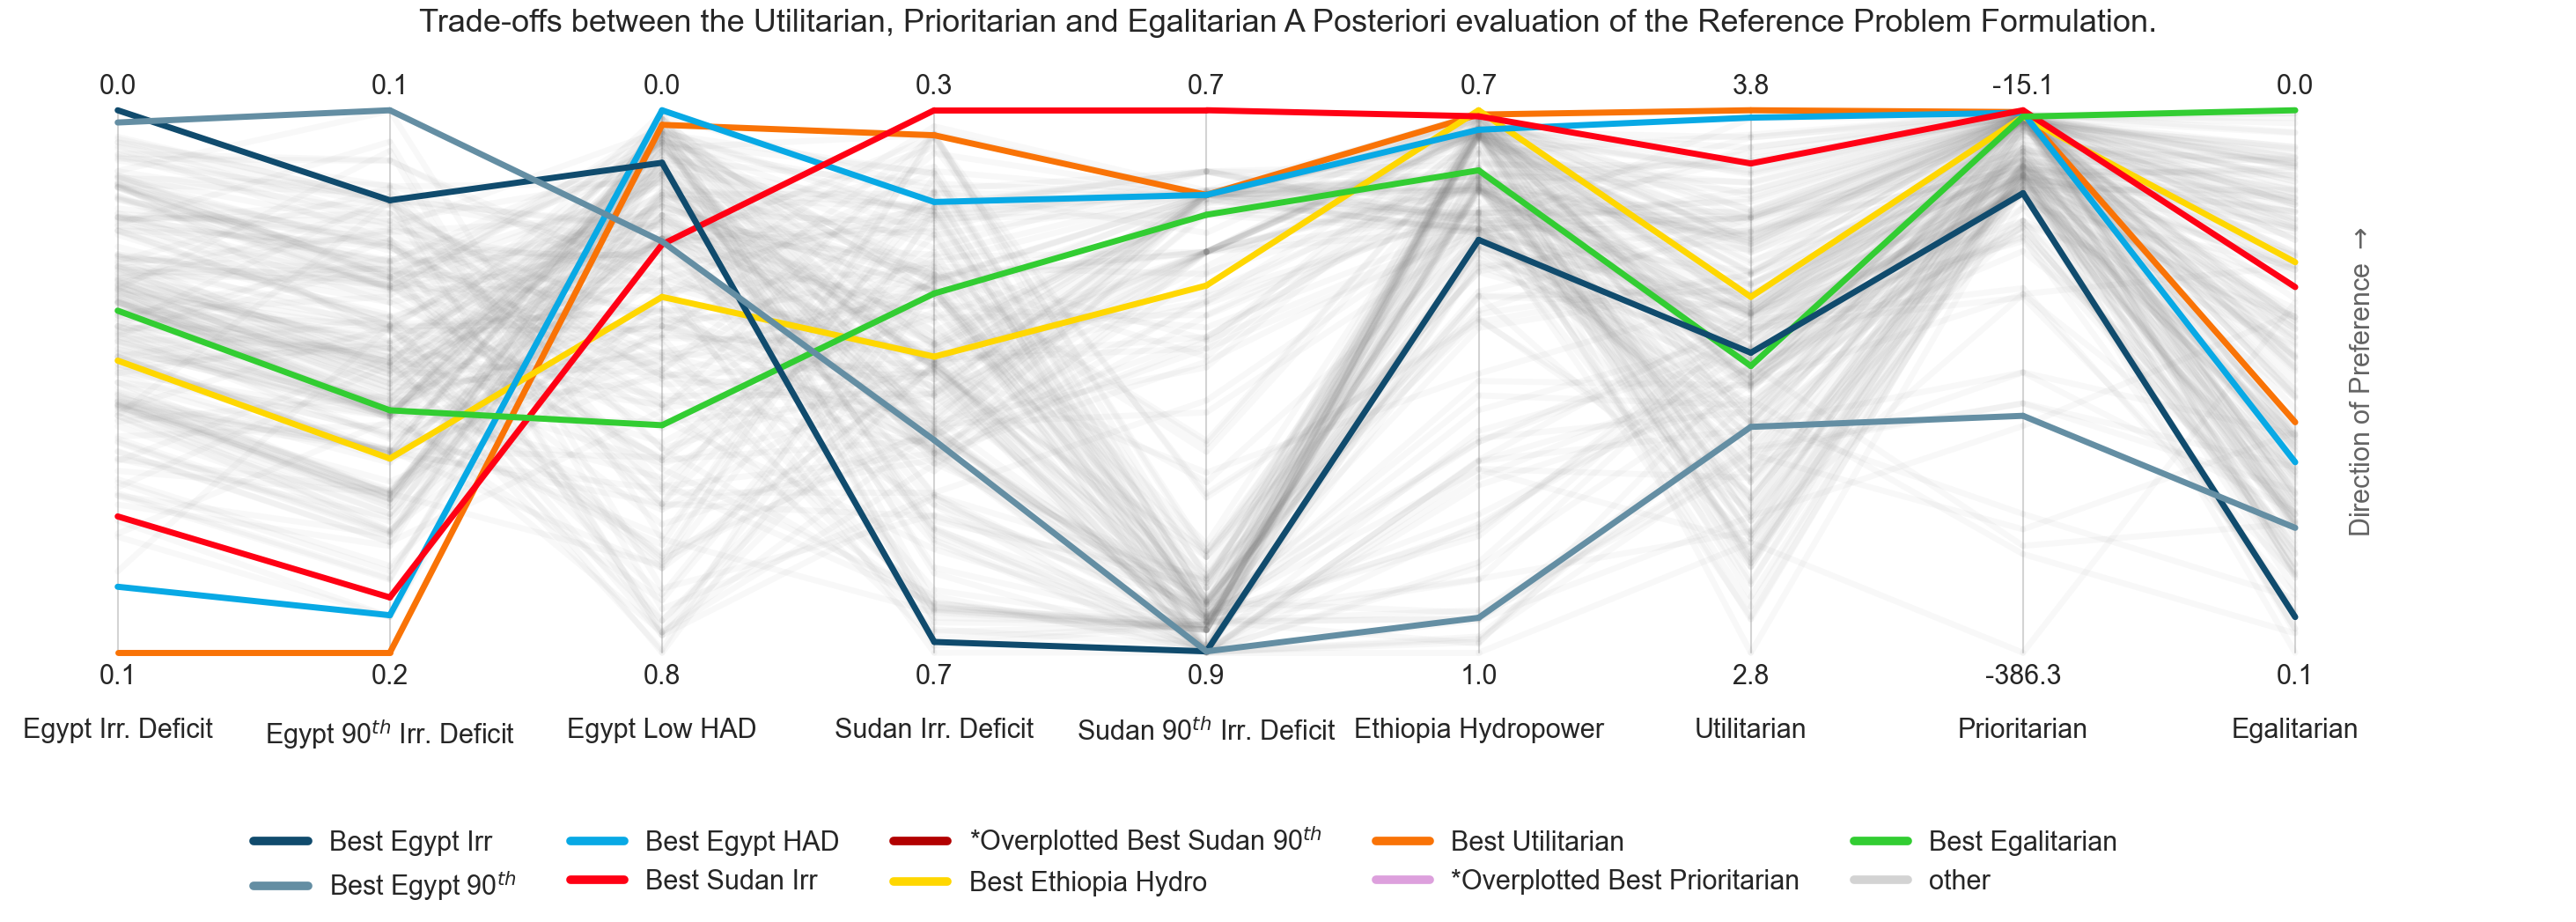

In [38]:
fig, ax = plt.subplots(figsize=(37.5, 12))

custom_parallel_coordinates(
    ax,
    df_swfs_None,
    columns_axes=objectives_broad, 
    axis_labels=[
            "Egypt Irr. Deficit",
            "Egypt 90$^{th}$ Irr. Deficit",
            "Egypt Low HAD",
            "Sudan Irr. Deficit",
            "Sudan 90$^{th}$ Irr. Deficit",
            "Ethiopia Hydropower",
            "Utilitarian",
            "Prioritarian",
            "Egalitarian",
    ],
    ideal_direction='top',
    directions=directions_broad,
    color_by_categorical='Category_broad',
    color_categories=created_vars_names_swfs_None_broad,
    brushing_dict = {'Category_broad': (['other'], '!=')},
    title = 'Trade-offs between the Utilitarian, Prioritarian and Egalitarian A Posteriori evaluation of the Reference Problem Formulation.' 
    )

plt.show()

In [39]:

df_swfs_None['pwf_rank'] = df_swfs_None['total_pwf'].rank(method='dense', ascending=False).astype(int)
df_swfs_None

egypt_agg_deficit_ratio  egypt_90p_deficit_ratio  \
Index                                                     
0                     0.059863                 0.189728   
1                     0.062170                 0.188981   
2                     0.064460                 0.198946   
3                     0.061862                 0.189675   
4                     0.064488                 0.198994   
...                        ...                      ...   
202                   0.055046                 0.165804   
203                   0.056846                 0.180048   
204                   0.049067                 0.150446   
205                   0.044377                 0.117045   
206                   0.047062                 0.128916   

       egypt_low_had_frequency  sudan_agg_deficit_ratio  \
Index                                                     
0                     0.137500                 0.447351   
1                     0.183333                 0.464333   
2                     0.020833                 0.602078   
3                     0.383333                 0.442585   
4                     0.037500                 0.509928   
...                        ...                      ...   
202                   0.591667                 0.536966   
203                   0.350000                 0.528810   
204                   0.208333                 0.526988   
205                   0.187500                 0.541714   
206                   0.266667                 0.536243   

       sudan_90p_deficit_ratio  ethiopia_agg_deficit_ratio  \
Index                                                        
0                     0.887193                    0.775475   
1                     0.740000                    0.749739   
2                     0.897248                    0.721120   
3                     0.754036                    0.746443   
4                     0.732470                    0.742275   
...                        ...                         ...   
202                   0.732470                    0.739655   
203                   0.732470                    0.748325   
204                   0.892661                    0.836296   
205                   0.905381                    0.944782   
206                   0.893955                    0.941379   

       utilitarian_welfare   total_pwf  gini_index       Category_narrow  \
Index                                                                      
0                 3.502890  -52.845936    0.057497                 other   
1                 3.611443  -19.200643    0.053016                 other   
2                 3.495314  -58.815904    0.064419                 other   
3                 3.422065  -20.295470    0.042288                 other   
4                 3.714346  -18.485686    0.061386                 other   
...                    ...         ...         ...                   ...   
202               3.178393  -20.972048    0.042510                 other   
203               3.403501  -19.621068    0.045661                 other   
204               3.336209  -66.332207    0.057815                 other   
205               3.259201 -224.159988    0.062116  Best Egypt 90$^{th}$   
206               3.185778 -194.425969    0.057119                 other   

             Category_broad  pwf_rank  
Index                                  
0                     other       121  
1                     other        41  
2                     other       141  
3                     other        56  
4                     other        30  
...                     ...       ...  
202                   other        63  
203                   other        48  
204                   other       165  
205    Best Egypt 90$^{th}$       201  
206                   other       197  

[207 rows x 12 columns]

In [40]:
objectives_rankedpwf = ['egypt_agg_deficit_ratio', 'egypt_90p_deficit_ratio', 'egypt_low_had_frequency', 'sudan_agg_deficit_ratio', 'sudan_90p_deficit_ratio', 'ethiopia_agg_deficit_ratio', 'utilitarian_welfare', 'pwf_rank', 'gini_index']
directions_rankedpwf = directions_narrow.copy()
directions_rankedpwf.update({'utilitarian_welfare': 'max', 'pwf_rank': 'min', 'gini_index': 'min'})

In [41]:
best_solutions_swfs_None_rankedpwf = get_best_solutions(df_swfs_None[objectives_rankedpwf], directions_rankedpwf)
created_vars_names_swfs_None_rankedpwf, created_vars_swfs_None_rankedpwf = create_global_variables(best_solutions_swfs_None_rankedpwf, policies_broad)
print(best_solutions_swfs_None_rankedpwf)

Best Egypt Irr
Best Egypt 90$^{th}$
Best Egypt HAD
Best Sudan Irr
*Overplotted Best Sudan 90$^{th}$
ov: *Overplotted Best Sudan 90$^{th}$
Best Ethiopia Hydro
Best Utilitarian
*Overplotted Best Prioritarian
ov: *Overplotted Best Prioritarian
Best Egalitarian
{'egypt_agg_deficit_ratio': 178, 'egypt_90p_deficit_ratio': 205, 'egypt_low_had_frequency': 99, 'sudan_agg_deficit_ratio': 120, 'sudan_90p_deficit_ratio': 120, 'ethiopia_agg_deficit_ratio': 59, 'utilitarian_welfare': 16, 'pwf_rank': 120, 'gini_index': 175}


In [42]:
### Now color by a categorical variable that isnt one of the axes
df_swfs_None["Category_rankedpwf"] = 'other'
for solution_index, policy in created_vars_swfs_None_rankedpwf.items():
    df_swfs_None.loc[solution_index, "Category_rankedpwf"] = policy
df_swfs_None

egypt_agg_deficit_ratio  egypt_90p_deficit_ratio  \
Index                                                     
0                     0.059863                 0.189728   
1                     0.062170                 0.188981   
2                     0.064460                 0.198946   
3                     0.061862                 0.189675   
4                     0.064488                 0.198994   
...                        ...                      ...   
202                   0.055046                 0.165804   
203                   0.056846                 0.180048   
204                   0.049067                 0.150446   
205                   0.044377                 0.117045   
206                   0.047062                 0.128916   

       egypt_low_had_frequency  sudan_agg_deficit_ratio  \
Index                                                     
0                     0.137500                 0.447351   
1                     0.183333                 0.464333   
2                     0.020833                 0.602078   
3                     0.383333                 0.442585   
4                     0.037500                 0.509928   
...                        ...                      ...   
202                   0.591667                 0.536966   
203                   0.350000                 0.528810   
204                   0.208333                 0.526988   
205                   0.187500                 0.541714   
206                   0.266667                 0.536243   

       sudan_90p_deficit_ratio  ethiopia_agg_deficit_ratio  \
Index                                                        
0                     0.887193                    0.775475   
1                     0.740000                    0.749739   
2                     0.897248                    0.721120   
3                     0.754036                    0.746443   
4                     0.732470                    0.742275   
...                        ...                         ...   
202                   0.732470                    0.739655   
203                   0.732470                    0.748325   
204                   0.892661                    0.836296   
205                   0.905381                    0.944782   
206                   0.893955                    0.941379   

       utilitarian_welfare   total_pwf  gini_index       Category_narrow  \
Index                                                                      
0                 3.502890  -52.845936    0.057497                 other   
1                 3.611443  -19.200643    0.053016                 other   
2                 3.495314  -58.815904    0.064419                 other   
3                 3.422065  -20.295470    0.042288                 other   
4                 3.714346  -18.485686    0.061386                 other   
...                    ...         ...         ...                   ...   
202               3.178393  -20.972048    0.042510                 other   
203               3.403501  -19.621068    0.045661                 other   
204               3.336209  -66.332207    0.057815                 other   
205               3.259201 -224.159988    0.062116  Best Egypt 90$^{th}$   
206               3.185778 -194.425969    0.057119                 other   

             Category_broad  pwf_rank    Category_rankedpwf  
Index                                                        
0                     other       121                 other  
1                     other        41                 other  
2                     other       141                 other  
3                     other        56                 other  
4                     other        30                 other  
...                     ...       ...                   ...  
202                   other        63                 other  
203                   other        48                 other  
204                   other       165                 o

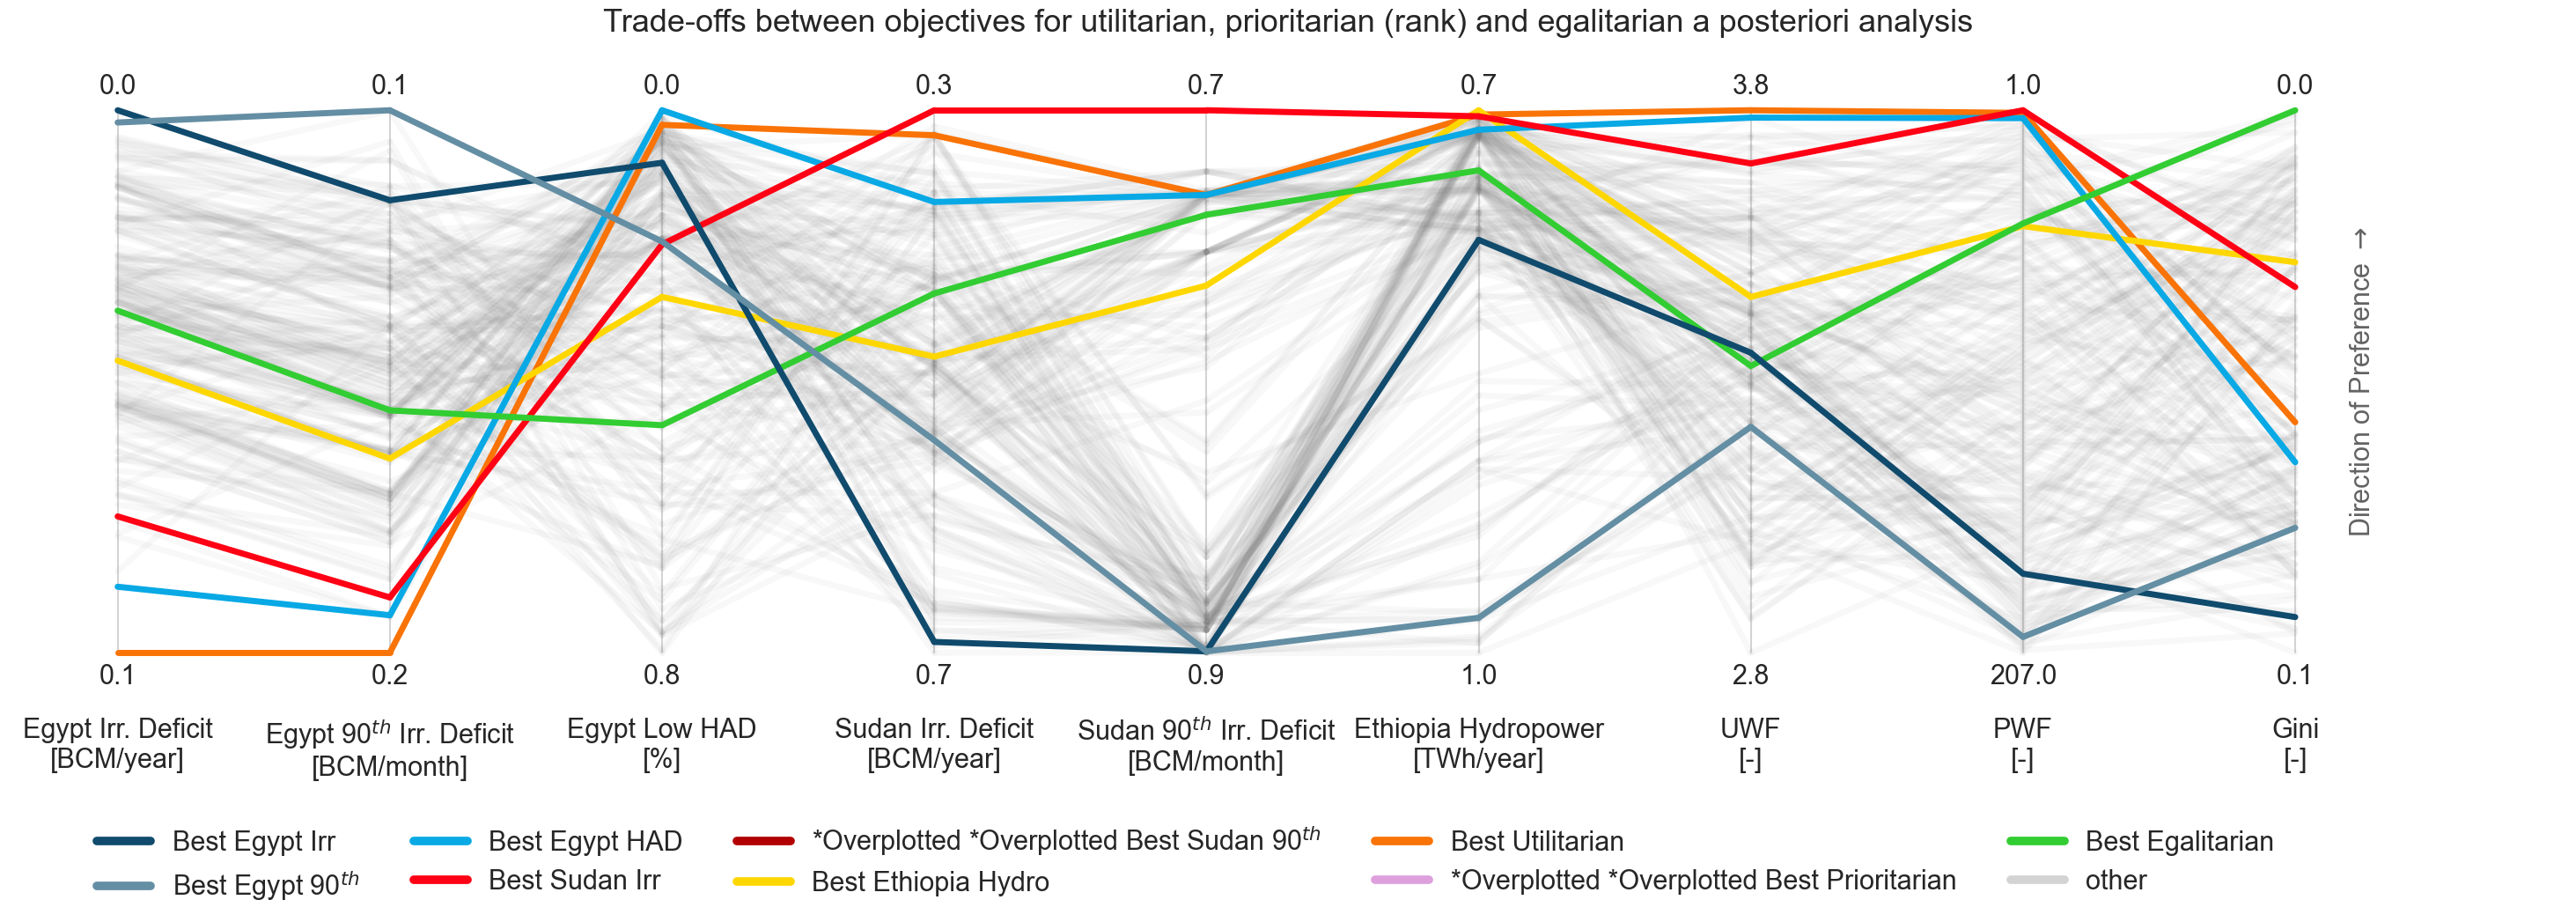

In [43]:
fig, ax = plt.subplots(figsize=(37.5, 12))

custom_parallel_coordinates(
    ax,
    df_swfs_None,
    columns_axes=objectives_rankedpwf, 
    axis_labels=[
            "Egypt Irr. Deficit",
            "Egypt 90$^{th}$ Irr. Deficit",
            "Egypt Low HAD",
            "Sudan Irr. Deficit",
            "Sudan 90$^{th}$ Irr. Deficit",
            "Ethiopia Hydropower",
            "UWF",
            "PWF",
            "Gini",
    ],
    units=["BCM/year", "BCM/month", "%", "BCM/year", "BCM/month", "TWh/year", "-", "-", "-"],
    ideal_direction='top',
    directions=directions_rankedpwf,
    color_by_categorical='Category_rankedpwf',
    color_categories=created_vars_names_swfs_None_rankedpwf,
    brushing_dict = {'Category_rankedpwf': (['other'], '!=')},
    title='Trade-offs between objectives for utilitarian, prioritarian (rank) and egalitarian a posteriori analysis'
    )

plt.show()

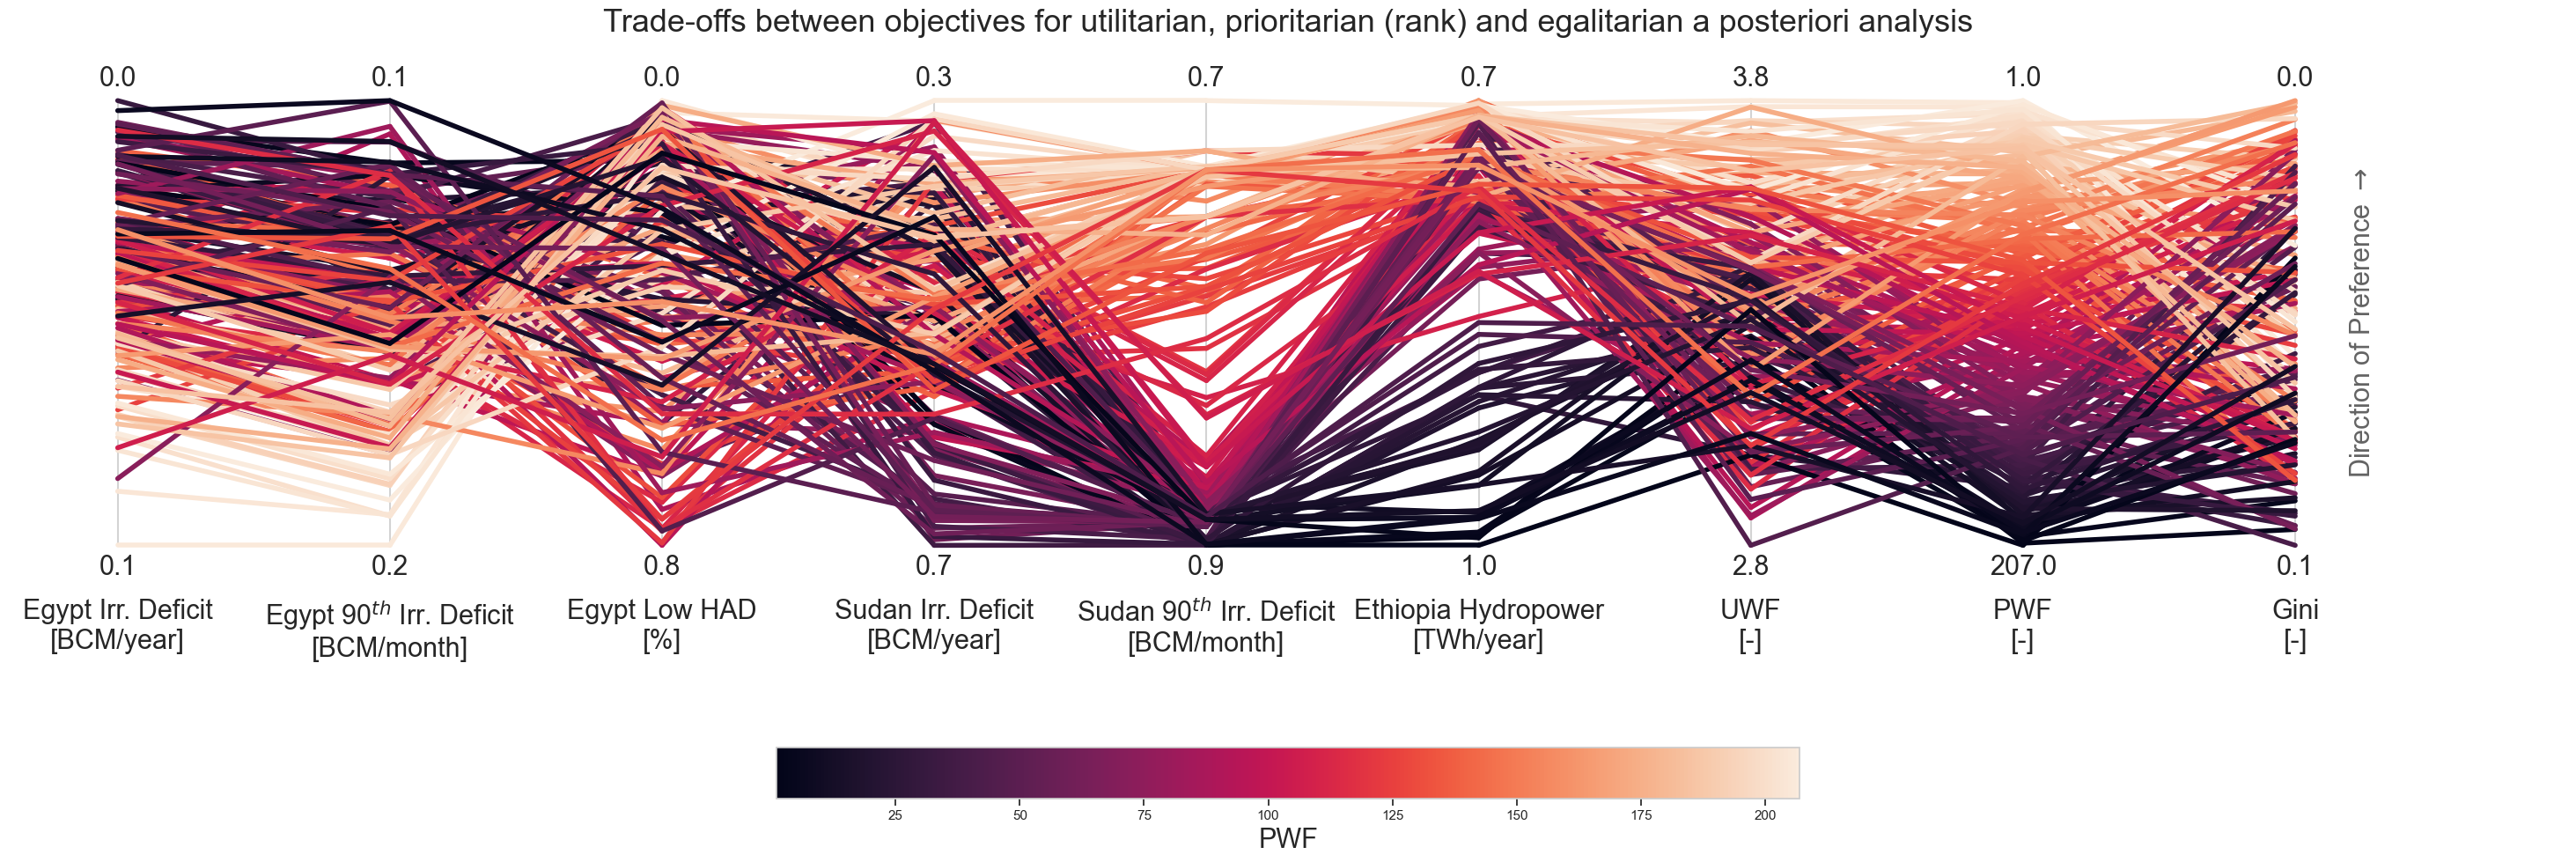

In [44]:
fig, ax = plt.subplots(figsize=(37.5, 12))

custom_parallel_coordinates(
    ax,
    df_swfs_None,
    columns_axes=objectives_rankedpwf, 
    axis_labels=[
            "Egypt Irr. Deficit",
            "Egypt 90$^{th}$ Irr. Deficit",
            "Egypt Low HAD",
            "Sudan Irr. Deficit",
            "Sudan 90$^{th}$ Irr. Deficit",
            "Ethiopia Hydropower",
            "UWF",
            "PWF",
            "Gini",
    ],
    units=["BCM/year", "BCM/month", "%", "BCM/year", "BCM/month", "TWh/year", "-", "-", "-"],
    ideal_direction='top',
    directions=directions_rankedpwf,
    color_by_continuous='pwf_rank',
    lw_base=4,
    title='Trade-offs between objectives for utilitarian, prioritarian (rank) and egalitarian a posteriori analysis'
    )

plt.show()

## 3.3 A Priori Results

In [45]:
objectives_broad = ['egypt_agg_deficit_ratio', 'egypt_90p_deficit_ratio', 'egypt_low_had_frequency', 'sudan_agg_deficit_ratio', 'sudan_90p_deficit_ratio', 'ethiopia_agg_deficit_ratio', 'utilitarian_welfare', 'total_pwf', 'gini_index']

# Create a copy of directions_narrow
directions_broad = directions_narrow.copy()

# Update directions_broad with additional key-value pairs
directions_broad.update({'utilitarian_welfare': 'max', 'total_pwf': 'max', 'gini_index': 'min'})

In [46]:
df_swfs_exps

egypt_agg_deficit_ratio  egypt_90p_deficit_ratio  \
Principle Index                                                     
None      0                     0.059863                 0.189728   
          1                     0.062170                 0.188981   
          2                     0.064460                 0.198946   
          3                     0.061862                 0.189675   
          4                     0.064488                 0.198994   
...                                  ...                      ...   
gini      333                   0.058888                 0.185044   
          334                   0.269800                 1.000000   
          335                   0.048625                 0.152609   
          336                   0.099155                 0.162350   
          337                   0.056078                 0.176157   

                 egypt_low_had_frequency  sudan_agg_deficit_ratio  \
Principle Index                                                     
None      0                     0.137500                 0.447351   
          1                     0.183333                 0.464333   
          2                     0.020833                 0.602078   
          3                     0.383333                 0.442585   
          4                     0.037500                 0.509928   
...                                  ...                      ...   
gini      333                   0.262500                 0.383202   
          334                   0.900000                 0.434169   
          335                   0.195833                 0.686921   
          336                   0.700000                 0.645428   
          337                   0.095833                 0.493905   

                 sudan_90p_deficit_ratio  ethiopia_agg_deficit_ratio  \
Principle Index                                                        
None      0                     0.887193                    0.775475   
          1                     0.740000                    0.749739   
          2                     0.897248                    0.721120   
          3                     0.754036                    0.746443   
          4                     0.732470                    0.742275   
...                                  ...                         ...   
gini      333                   0.875075                    0.849522   
          334                   0.892256                    0.820905   
          335                   0.903032                    0.757236   
          336                   0.905318                    0.768033   
          337                   0.886140                    0.813899   

                 principle_result  utilitarian_welfare   total_pwf  gini_index  
Principle Index                                                                 
None      0                   NaN             3.502890  -52.845936    0.057497  
          1                   NaN             3.611443  -19.200643    0.053016  
          2                   NaN             3.495314  -58.815904    0.064419  
          3                   NaN             3.422065  -20.295470    0.042288  
          4                   NaN             3.714346  -18.485686    0.061386  
...                           ...                  ...         ...         ...  
gini      333            0.605042             3.385769  -57.670601    0.054394  
          334            0.802344             1.682869 -111.158951    0.028378  
          335            0.600559             3.255744  -68.783051    0.059218  
          336            0.700105             2.719717  -75.928109    0.042269  
          337            0.562370             3.477988  -56.866261    0.061653  

[1002 rows x 10 columns]

In [47]:
# Group the DataFrame by 'Principle' level and get the unique principles in the original order
principles_order = df_swfs_exps.index.get_level_values('Principle').unique()

# Create an empty dictionary to store the results
swfs_exps_dict = {}

# Iterate through unique principles in the original order and store corresponding DataFrames in the dictionary
for principle in principles_order:
    principle_data = df_swfs_exps.drop(columns='principle_result').loc[df_swfs_exps.index.get_level_values('Principle') == principle]
    swfs_exps_dict[principle] = principle_data


In [48]:
# Initialize empty dictionaries
best_solutions_dict = {}
created_vars_names_dict = {}
created_vars_dict = {}

# Iterate through the dictionary
for key, obj_df in swfs_exps_dict.items():
    # Calculate best solutions, created variables, and variable names
    best_solutions = get_best_solutions(obj_df, directions_broad)
    created_vars_names, created_vars = create_global_variables(best_solutions, policies_broad)

    # Store the results in dictionaries using the dataframe's key as the key in the dictionary
    best_solutions_dict[key] = best_solutions
    created_vars_names_dict[key] = created_vars_names
    created_vars_dict[key] = created_vars
    print(created_vars)
    ### Now color by a categorical variable that isnt one of the axes
    obj_df["Category_broad"] = 'other'
    for solution_index, policy in created_vars.items():
        obj_df.loc[solution_index, "Category_broad"] = policy

Best Egypt Irr
Best Egypt 90$^{th}$
ov: Best Egypt 90$^{th}$
Best Egypt HAD
ov: Best Egypt HAD
Best Sudan Irr
ov: Best Sudan Irr
*Overplotted *Overplotted Best Sudan 90$^{th}$
ov: *Overplotted *Overplotted Best Sudan 90$^{th}$
Best Ethiopia Hydro
ov: Best Ethiopia Hydro
Best Utilitarian
ov: Best Utilitarian
*Overplotted *Overplotted Best Prioritarian
ov: *Overplotted *Overplotted Best Prioritarian
Best Egalitarian
ov: Best Egalitarian
{'None': 'Best Egypt Irr', 178: 'Best Egypt Irr', 205: 'Best Egypt 90$^{th}$', 99: 'Best Egypt HAD', 120: '*Overplotted *Overplotted Best Prioritarian', 59: 'Best Ethiopia Hydro', 16: 'Best Utilitarian', 175: 'Best Egalitarian'}
Best Egypt Irr
*Overplotted Best Egypt 90$^{th}$
ov: *Overplotted Best Egypt 90$^{th}$
*Overplotted Best Egypt HAD
ov: *Overplotted Best Egypt HAD
*Overplotted Best Sudan Irr
ov: *Overplotted Best Sudan Irr
*Overplotted *Overplotted *Overplotted Best Sudan 90$^{th}$
ov: *Overplotted *Overplotted *Overplotted Best Sudan 90$^{th}$
*

In [49]:
directions_broad

{'egypt_agg_deficit_ratio': 'min',
 'egypt_90p_deficit_ratio': 'min',
 'egypt_low_had_frequency': 'min',
 'sudan_agg_deficit_ratio': 'min',
 'sudan_90p_deficit_ratio': 'min',
 'ethiopia_agg_deficit_ratio': 'min',
 'utilitarian_welfare': 'max',
 'total_pwf': 'max',
 'gini_index': 'min'}

In [50]:
# Initialize dictionaries to store min and max values
min_dict = {}
max_dict = {}

# Iterate through the dataframes in swfs_exps_dict
for key, df in swfs_exps_dict.items():
    # Calculate min and max values for each column (except 'Category_broad')
    for column in df.columns:
        if column != 'Category_broad':
            min_dict[column] = min(min_dict.get(column, float('inf')), df[column].min())
            max_dict[column] = max(max_dict.get(column, float('-inf')), df[column].max())

# Add 'Category_broad' to the dictionaries
min_dict['Category_broad'] = 'minmax'
max_dict['Category_broad'] = 'minmax'

# Create a single dataframe for min and max rows with 'Category_broad' as the final column
min_max_df = pd.DataFrame([min_dict, max_dict])
min_max_df


egypt_agg_deficit_ratio  egypt_90p_deficit_ratio  egypt_low_had_frequency  \
0                 0.043326                 0.105818                 0.000000   
1                 0.309014                 1.000000                 0.933333   

   sudan_agg_deficit_ratio  sudan_90p_deficit_ratio  \
0                 0.299523                 0.700405   
1                 0.695592                 0.905889   

   ethiopia_agg_deficit_ratio  utilitarian_welfare   total_pwf  gini_index  \
0                    0.712159             1.605931 -415.457461    0.022264   
1                    0.962438             3.875126  -14.927602    0.069303   

  Category_broad  
0         minmax  
1         minmax

In [51]:
for key, value in swfs_exps_dict.items():
    print("Dictionary Key:", key)

Dictionary Key: None
Dictionary Key: uwf
Dictionary Key: pwf
Dictionary Key: gini


TypeError: <lambda>() missing 1 required positional argument: 'x'

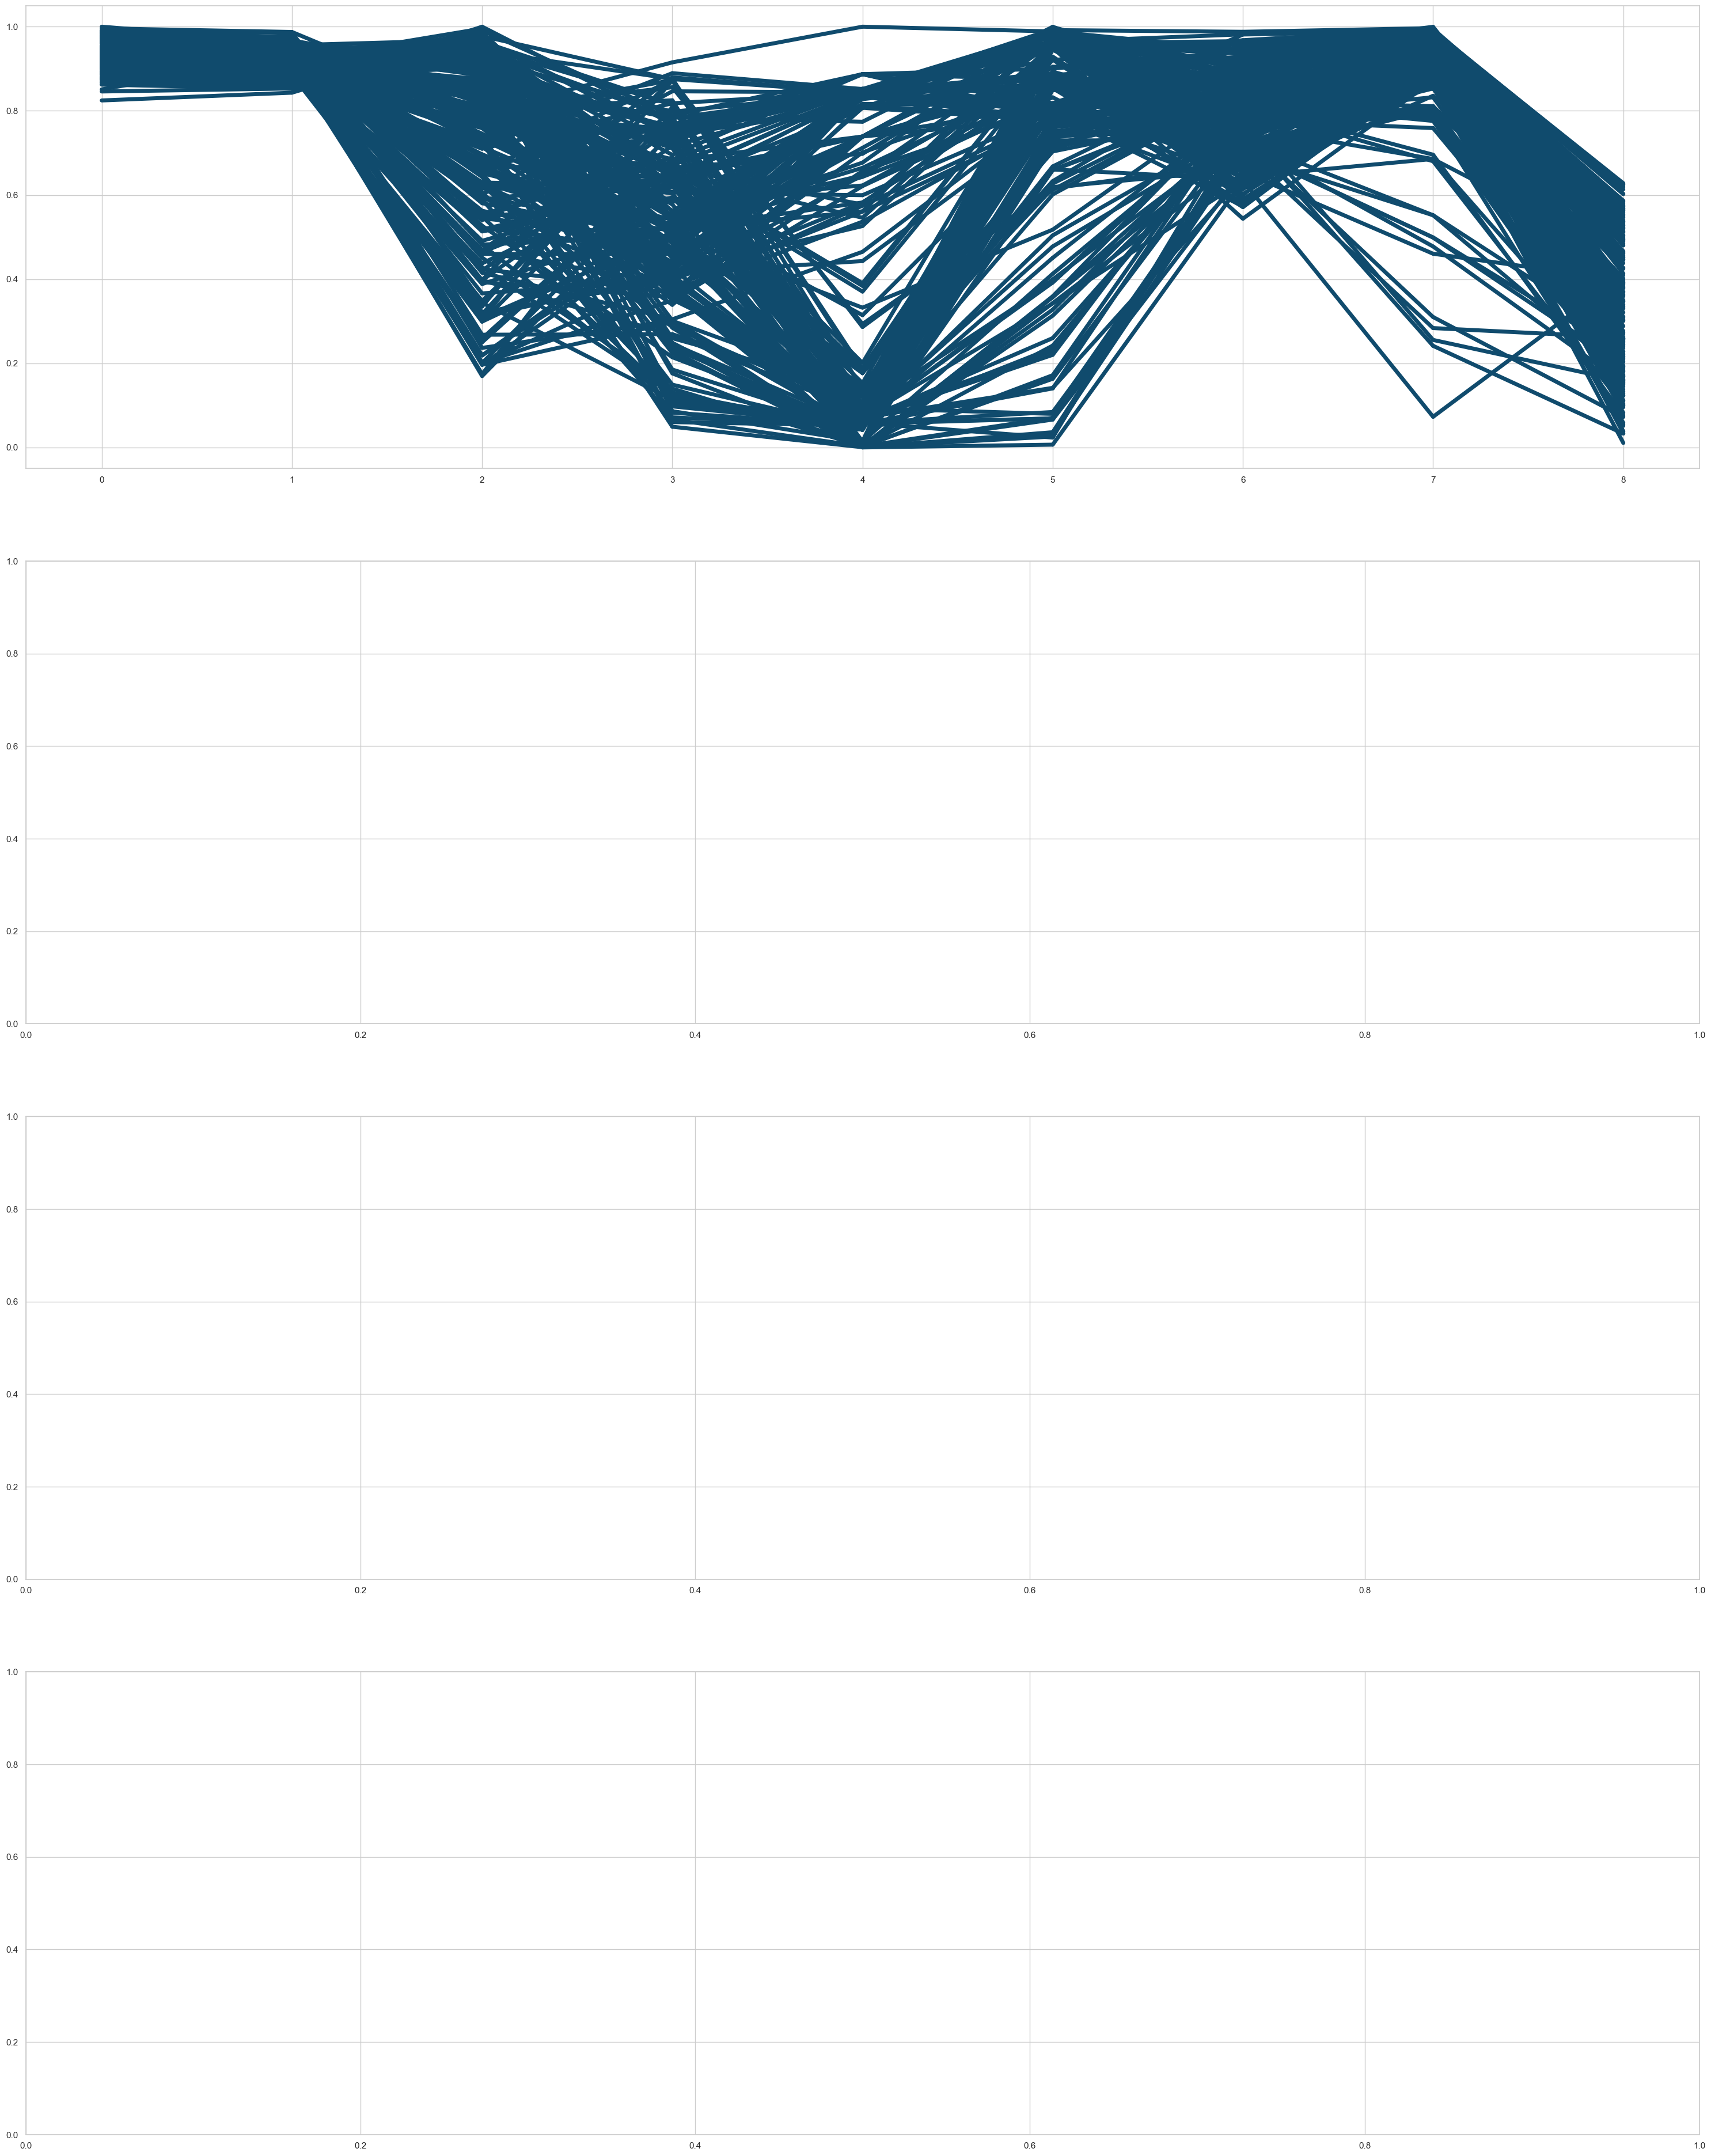

In [52]:
# Create subplots in a grid where each subplot shares the same y-axis
n_plots = len(swfs_exps_dict)
fig, axes = plt.subplots(n_plots, 1, figsize=(37.5, 12*n_plots))
# Iterate through the dictionary
for idx, (key, df) in enumerate(swfs_exps_dict.items()):
    df_plot = df.droplevel(level='Principle')
    ax=axes[idx]
    custom_parallel_coordinates(
        ax,
        df_plot,
        min_max_df,
        columns_axes=objectives_broad,
        axis_labels=[
            "Egypt Irr. Deficit",
            "Egypt 90$^{th}$ Irr. Deficit",
            "Egypt Low HAD",
            "Sudan Irr. Deficit",
            "Sudan 90$^{th}$ Irr. Deficit",
            "Ethiopia Hydropower",
            "UWF",
            "PWF",
            "Gini",
        ],
        units=["%", "%", "%", "%", "%", "%", "-", "-", "-"],
        ideal_direction='top',
        directions=directions_broad,
        color_by_categorical='Category_broad',
        color_categories=created_vars_names_dict[key],
        brushing_dict={'Category_broad': (['other', 'minmax'], '!=')},
        title=key,
    )
 
# Show the entire plot after all subplots have been created
fig.suptitle('Trade-offs between objectives for utilitarian, prioritarian and egalitarian a priori analysis', va='bottom', fontsize=26)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()


### 3.3.1 3D plot

In [ ]:
df_swfs_exps

egypt_agg_deficit_ratio  egypt_90p_deficit_ratio  \
Principle Index                                                     
None      0                     0.059863                 0.189728   
          1                     0.062170                 0.188981   
          2                     0.064460                 0.198946   
          3                     0.061862                 0.189675   
          4                     0.064488                 0.198994   
...                                  ...                      ...   
gini      333                   0.058888                 0.185044   
          334                   0.269800                 1.000000   
          335                   0.048625                 0.152609   
          336                   0.099155                 0.162350   
          337                   0.056078                 0.176157   

                 egypt_low_had_frequency  sudan_agg_deficit_ratio  \
Principle Index                                                     
None      0                     0.137500                 0.447351   
          1                     0.183333                 0.464333   
          2                     0.020833                 0.602078   
          3                     0.383333                 0.442585   
          4                     0.037500                 0.509928   
...                                  ...                      ...   
gini      333                   0.262500                 0.383202   
          334                   0.900000                 0.434169   
          335                   0.195833                 0.686921   
          336                   0.700000                 0.645428   
          337                   0.095833                 0.493905   

                 sudan_90p_deficit_ratio  ethiopia_agg_deficit_ratio  \
Principle Index                                                        
None      0                     0.887193                    0.775475   
          1                     0.740000                    0.749739   
          2                     0.897248                    0.721120   
          3                     0.754036                    0.746443   
          4                     0.732470                    0.742275   
...                                  ...                         ...   
gini      333                   0.875075                    0.849522   
          334                   0.892256                    0.820905   
          335                   0.903032                    0.757236   
          336                   0.905318                    0.768033   
          337                   0.886140                    0.813899   

                 principle_result  utilitarian_welfare   total_pwf  gini_index  
Principle Index                                                                 
None      0                   NaN             3.502890  -52.845936    0.057497  
          1                   NaN             3.611443  -19.200643    0.053016  
          2                   NaN             3.495314  -58.815904    0.064419  
          3                   NaN             3.422065  -20.295470    0.042288  
          4                   NaN             3.714346  -18.485686    0.061386  
...                           ...                  ...         ...         ...  
gini      333            0.605042             3.385769  -57.670601    0.054394  
          334            0.802344             1.682869 -111.158951    0.028378  
          335            0.600559             3.255744  -68.783051    0.059218  
          336            0.700105             2.719717  -75.928109    0.042269  
          337            0.562370             3.477988  -56.866261    0.061653  

[1002 rows x 10 columns]

In [ ]:
df_swfs_exps

egypt_agg_deficit_ratio  egypt_90p_deficit_ratio  \
Principle Index                                                     
None      0                     0.059863                 0.189728   
          1                     0.062170                 0.188981   
          2                     0.064460                 0.198946   
          3                     0.061862                 0.189675   
          4                     0.064488                 0.198994   
...                                  ...                      ...   
gini      333                   0.058888                 0.185044   
          334                   0.269800                 1.000000   
          335                   0.048625                 0.152609   
          336                   0.099155                 0.162350   
          337                   0.056078                 0.176157   

                 egypt_low_had_frequency  sudan_agg_deficit_ratio  \
Principle Index                                                     
None      0                     0.137500                 0.447351   
          1                     0.183333                 0.464333   
          2                     0.020833                 0.602078   
          3                     0.383333                 0.442585   
          4                     0.037500                 0.509928   
...                                  ...                      ...   
gini      333                   0.262500                 0.383202   
          334                   0.900000                 0.434169   
          335                   0.195833                 0.686921   
          336                   0.700000                 0.645428   
          337                   0.095833                 0.493905   

                 sudan_90p_deficit_ratio  ethiopia_agg_deficit_ratio  \
Principle Index                                                        
None      0                     0.887193                    0.775475   
          1                     0.740000                    0.749739   
          2                     0.897248                    0.721120   
          3                     0.754036                    0.746443   
          4                     0.732470                    0.742275   
...                                  ...                         ...   
gini      333                   0.875075                    0.849522   
          334                   0.892256                    0.820905   
          335                   0.903032                    0.757236   
          336                   0.905318                    0.768033   
          337                   0.886140                    0.813899   

                 principle_result  utilitarian_welfare   total_pwf  gini_index  
Principle Index                                                                 
None      0                   NaN             3.502890  -52.845936    0.057497  
          1                   NaN             3.611443  -19.200643    0.053016  
          2                   NaN             3.495314  -58.815904    0.064419  
          3                   NaN             3.422065  -20.295470    0.042288  
          4                   NaN             3.714346  -18.485686    0.061386  
...                           ...                  ...         ...         ...  
gini      333            0.605042             3.385769  -57.670601    0.054394  
          334            0.802344             1.682869 -111.158951    0.028378  
          335            0.600559             3.255744  -68.783051    0.059218  
          336            0.700105             2.719717  -75.928109    0.042269  
          337            0.562370             3.477988  -56.866261    0.061653  

[1002 rows x 10 columns]

In [ ]:
objectives_scatter = ['egypt_agg_deficit_ratio', 'sudan_agg_deficit_ratio', 'ethiopia_agg_deficit_ratio', ]
df_scatter = df_swfs_exps[objectives_scatter].reset_index().drop(columns='Index')
df_scatter

Principle  egypt_agg_deficit_ratio  sudan_agg_deficit_ratio  \
0         None                 0.059863                 0.447351   
1         None                 0.062170                 0.464333   
2         None                 0.064460                 0.602078   
3         None                 0.061862                 0.442585   
4         None                 0.064488                 0.509928   
...        ...                      ...                      ...   
997       gini                 0.058888                 0.383202   
998       gini                 0.269800                 0.434169   
999       gini                 0.048625                 0.686921   
1000      gini                 0.099155                 0.645428   
1001      gini                 0.056078                 0.493905   

      ethiopia_agg_deficit_ratio  
0                       0.775475  
1                       0.749739  
2                       0.721120  
3                       0.746443  
4                       0.742275  
...                          ...  
997                     0.849522  
998                     0.820905  
999                     0.757236  
1000                    0.768033  
1001                    0.813899  

[1002 rows x 4 columns]

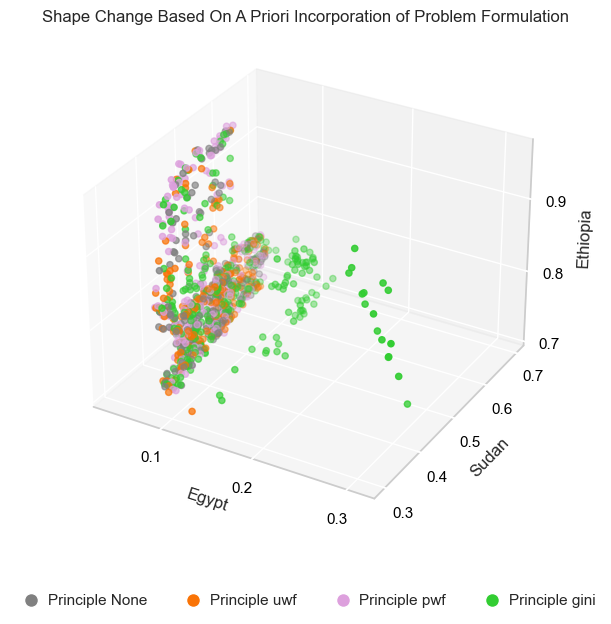

In [ ]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 12))
# Define the position and size of the subplot within the figure
left, bottom, width, height = 0.05, 0.1, 0.5, 0.8
rect = [left, bottom, width, height]

# Create a 3D subplot using add_axes with specified rect parameter
ax = fig.add_axes(rect, projection='3d')

# Map 'Principle' values to custom colors and create a new column 'Principle_color'
df_plot=df_scatter.copy()
df_plot['Principle_color'] = df_plot['Principle'].map(principle_colors)

# Plot the data points with different hues based on the first index level
ax.scatter(df_plot['egypt_agg_deficit_ratio'], df_plot['sudan_agg_deficit_ratio'], df_plot['ethiopia_agg_deficit_ratio'], c=df_plot['Principle_color'])

# Set labels for the axes
ax.set_xlabel('Egypt')
ax.set_ylabel('Sudan')
ax.set_zlabel('Ethiopia')

# Set the title of the plot
ax.set_title('Shape Change Based On A Priori Incorporation of Problem Formulation')

# Set the color of grid lines to white
ax.xaxis._axinfo["grid"]['color'] = (1, 1, 1, 1)  # Red, Green, Blue, Alpha
ax.yaxis._axinfo["grid"]['color'] = (1, 1, 1, 1)  # Red, Green, Blue, Alpha
ax.zaxis._axinfo["grid"]['color'] = (1, 1, 1, 1)  # Red, Green, Blue, Alpha

# Set custom locator for major ticks to increase spacing between grid lines
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.1))  # Set custom_x_spacing to the desired spacing between major ticks on the x-axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1))  # Set custom_y_spacing to the desired spacing between major ticks on the y-axis
ax.zaxis.set_major_locator(ticker.MultipleLocator(base=0.1))  # Set custom_z_spacing to the desired spacing between major ticks on the z-axis

# Set the color of ticks to match the grid lines
ax.tick_params(axis='both', which='both', length=4, color='white', width=1, labelcolor='black')  

# Add a legend
# Create custom legend handles for each unique principle
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Principle {label}') for label, color in principle_colors.items()]
legend = ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(principle_colors), frameon=False, handletextpad=0.1)

# Add whitespace to the right of the figure (adjust the right parameter as needed)
plt.subplots_adjust(right=0.8)

# Show the plot
plt.show()

In [ ]:
objectives_plot = ['egypt_agg_deficit_ratio', 'sudan_agg_deficit_ratio', 'ethiopia_agg_deficit_ratio', 'utilitarian_welfare']

# Reset the index and drop the old index column
df_swfs_exps_reset = df_swfs_exps[objectives_plot].reset_index().drop(columns='Index')

# Select rows where 'Principle' is 'None' or 'uwf', and select specified columns
df_plot = df_swfs_exps_reset[df_swfs_exps_reset['Principle'].isin(['None', 'uwf'])]
df_plot

Principle  egypt_agg_deficit_ratio  sudan_agg_deficit_ratio  \
0        None                 0.059863                 0.447351   
1        None                 0.062170                 0.464333   
2        None                 0.064460                 0.602078   
3        None                 0.061862                 0.442585   
4        None                 0.064488                 0.509928   
..        ...                      ...                      ...   
421       uwf                 0.068125                 0.347826   
422       uwf                 0.069462                 0.349775   
423       uwf                 0.054949                 0.571168   
424       uwf                 0.072469                 0.418373   
425       uwf                 0.067175                 0.497842   

     ethiopia_agg_deficit_ratio  utilitarian_welfare  
0                      0.775475             3.502890  
1                      0.749739             3.611443  
2                      0.721120             3.495314  
3                      0.746443             3.422065  
4                      0.742275             3.714346  
..                          ...                  ...  
421                    0.813924             3.612283  
422                    0.809656             3.611186  
423                    0.888893             3.086655  
424                    0.744489             3.060570  
425                    0.736572             3.046477  

[426 rows x 5 columns]

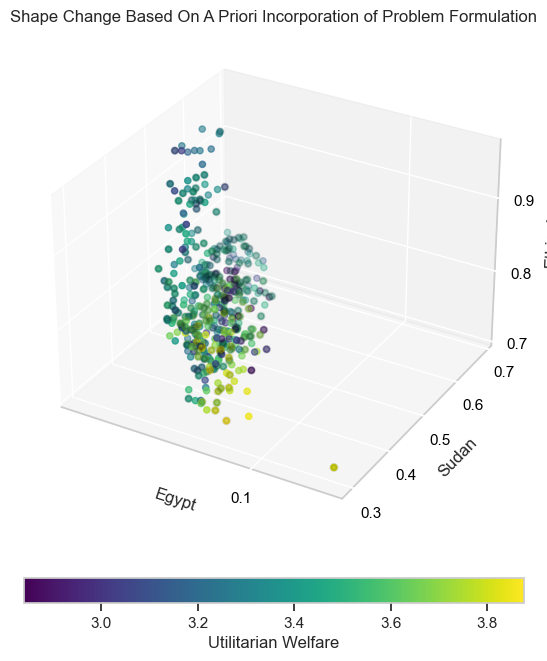

In [ ]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 12))
# Define the position and size of the subplot within the figure
left, bottom, width, height = 0.05, 0.1, 0.5, 0.8
rect = [left, bottom, width, height]

# Create a 3D subplot using add_axes with specified rect parameter
ax = fig.add_axes(rect, projection='3d')

# Plot the data points with different hues based on the first index level
scatter = ax.scatter(df_plot['egypt_agg_deficit_ratio'], df_plot['sudan_agg_deficit_ratio'], df_plot['ethiopia_agg_deficit_ratio'], c=df_plot['utilitarian_welfare'], cmap='viridis')

# Find indices of data points where 'Principle' column equals 'uwf'
highlight_indices = df_plot[df_plot['Principle'] == 'uwf'].index

ax.scatter(df_plot['egypt_agg_deficit_ratio'].iloc[highlight_indices], 
           df_plot['sudan_agg_deficit_ratio'].iloc[highlight_indices], 
           df_plot['ethiopia_agg_deficit_ratio'].iloc[highlight_indices], 
           c='black', alpha=0.1, edgecolors='black', linewidths=2)

# Set labels for the axes
ax.set_xlabel('Egypt')
ax.set_ylabel('Sudan')
ax.set_zlabel('Ethiopia')

# Set the title of the plot
ax.set_title('Shape Change Based On A Priori Incorporation of Problem Formulation')

# Set the color of grid lines to white
ax.xaxis._axinfo["grid"]['color'] = (1, 1, 1, 1)  # Red, Green, Blue, Alpha
ax.yaxis._axinfo["grid"]['color'] = (1, 1, 1, 1)  # Red, Green, Blue, Alpha
ax.zaxis._axinfo["grid"]['color'] = (1, 1, 1, 1)  # Red, Green, Blue, Alpha

# Set custom locator for major ticks to increase spacing between grid lines
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.1))  # Set custom_x_spacing to the desired spacing between major ticks on the x-axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1))  # Set custom_y_spacing to the desired spacing between major ticks on the y-axis
ax.zaxis.set_major_locator(ticker.MultipleLocator(base=0.1))  # Set custom_z_spacing to the desired spacing between major ticks on the z-axis

# Set the color of ticks to match the grid lines
ax.tick_params(axis='both', which='both', length=4, color='white', width=1, labelcolor='black')  

# Add a horizontal colorbar underneath the 3D plot
cbar = fig.colorbar(scatter, orientation='horizontal', pad=0.05, ax=ax)
cbar.set_label('Utilitarian Welfare')  # Set the label for the colorbar

# Show the plot
plt.show()

In [ ]:
objectives_plot = ['egypt_agg_deficit_ratio', 'sudan_agg_deficit_ratio', 'ethiopia_agg_deficit_ratio', 'gini_index']

# Reset the index and drop the old index column
df_swfs_exps_reset = df_swfs_exps[objectives_plot].reset_index().drop(columns='Index')

# Select rows where 'Principle' is 'None' or 'uwf', and select specified columns
df_plot = df_swfs_exps_reset[df_swfs_exps_reset['Principle'].isin(['None', 'gini'])].reset_index(drop=True)
df_plot

Principle  egypt_agg_deficit_ratio  sudan_agg_deficit_ratio  \
0        None                 0.059863                 0.447351   
1        None                 0.062170                 0.464333   
2        None                 0.064460                 0.602078   
3        None                 0.061862                 0.442585   
4        None                 0.064488                 0.509928   
..        ...                      ...                      ...   
540      gini                 0.058888                 0.383202   
541      gini                 0.269800                 0.434169   
542      gini                 0.048625                 0.686921   
543      gini                 0.099155                 0.645428   
544      gini                 0.056078                 0.493905   

     ethiopia_agg_deficit_ratio  gini_index  
0                      0.775475    0.057497  
1                      0.749739    0.053016  
2                      0.721120    0.064419  
3                      0.746443    0.042288  
4                      0.742275    0.061386  
..                          ...         ...  
540                    0.849522    0.054394  
541                    0.820905    0.028378  
542                    0.757236    0.059218  
543                    0.768033    0.042269  
544                    0.813899    0.061653  

[545 rows x 5 columns]

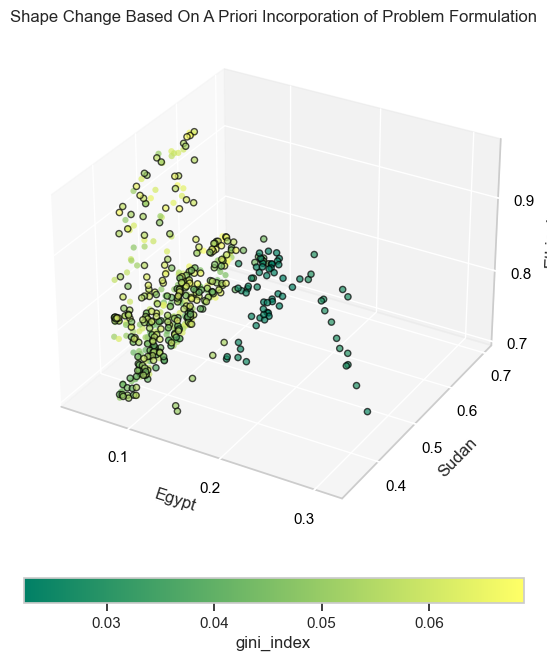

In [ ]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 12))
# Define the position and size of the subplot within the figure
left, bottom, width, height = 0.05, 0.1, 0.5, 0.8
rect = [left, bottom, width, height]

# Create a 3D subplot using add_axes with specified rect parameter
ax = fig.add_axes(rect, projection='3d')

# Choose a pastel tone colormap for high contrast
pastel_cmap = plt.cm.summer

# Check the min and max values for 'gini_index'
min_gini = df_plot['gini_index'].min()
max_gini = df_plot['gini_index'].max()

# Normalize 'gini_index' values to range from 0 to 1 for colormap mapping
norm = plt.Normalize(vmin=min_gini, vmax=max_gini)

# Create a ScalarMappable object to map values to colors using the custom colormap
sm = plt.cm.ScalarMappable(cmap=pastel_cmap, norm=norm)
sm.set_array([])  # empty array for the scalar mappable

# Plot scatter points for 'Principle' = None without edges
ax.scatter(df_plot.loc[df_plot['Principle'] == 'None', 'egypt_agg_deficit_ratio'],
           df_plot.loc[df_plot['Principle'] == 'None', 'sudan_agg_deficit_ratio'],
           df_plot.loc[df_plot['Principle'] == 'None', 'ethiopia_agg_deficit_ratio'],
           c=sm.to_rgba(df_plot.loc[df_plot['Principle'] == 'None', 'gini_index']),  # Use pastel tone colormap
           edgecolors='none', label='Principle: None', alpha=0.7)

# Plot scatter points for 'Principle' = gini with black edges
ax.scatter(df_plot.loc[df_plot['Principle'] == 'gini', 'egypt_agg_deficit_ratio'],
           df_plot.loc[df_plot['Principle'] == 'gini', 'sudan_agg_deficit_ratio'],
           df_plot.loc[df_plot['Principle'] == 'gini', 'ethiopia_agg_deficit_ratio'],
           c=sm.to_rgba(df_plot.loc[df_plot['Principle'] == 'gini', 'gini_index']),
           edgecolors='black', linewidth=1, label='Principle: Gini Index', alpha=0.7)

# Set labels for the axes
ax.set_xlabel('Egypt')
ax.set_ylabel('Sudan')
ax.set_zlabel('Ethiopia')

# Set the title of the plot
ax.set_title('Shape Change Based On A Priori Incorporation of Problem Formulation')

# Set the color of grid lines to white
ax.xaxis._axinfo["grid"]['color'] = (1, 1, 1, 1)  # Red, Green, Blue, Alpha
ax.yaxis._axinfo["grid"]['color'] = (1, 1, 1, 1)  # Red, Green, Blue, Alpha
ax.zaxis._axinfo["grid"]['color'] = (1, 1, 1, 1)  # Red, Green, Blue, Alpha

# Set custom locator for major ticks to increase spacing between grid lines
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.1))  # Set custom_x_spacing to the desired spacing between major ticks on the x-axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1))  # Set custom_y_spacing to the desired spacing between major ticks on the y-axis
ax.zaxis.set_major_locator(ticker.MultipleLocator(base=0.1))  # Set custom_z_spacing to the desired spacing between major ticks on the z-axis

# Set the color of ticks to match the grid lines
ax.tick_params(axis='both', which='both', length=4, color='white', width=1, labelcolor='black')  

# Add a horizontal colorbar underneath the 3D plot
cbar = fig.colorbar(sm, orientation='horizontal', pad=0.05, ax=ax)
cbar.set_label('gini_index')  # Set the label for the colorbar

# Show the plot
plt.show()

In [ ]:
fig = go.Figure(data=[go.Scatter3d(
    x=df_scatter['egypt_agg_deficit_ratio'],
    y=df_scatter['sudan_agg_deficit_ratio'],
    z=df_scatter['ethiopia_agg_deficit_ratio'],
    mode='markers',
    marker=dict(
        size=5,
        color=df_scatter['Principle_encoded'],
        colorscale='Viridis',
        opacity=0.8
    )
)])

fig.update_layout(
    title='Interactive 3D Scatterplot of countries main objective',
    scene=dict(
        xaxis_title='Egypt',
        yaxis_title='Sudan',
        zaxis_title='Ethiopia'
        )
    )
fig.show()

KeyError: 'Principle_encoded'

#### 2.2.5.2 Compare Utilirarianism with Prioritarian transformation

In [ ]:
# Extract the 'utilitarian_welfare' and 'total_pwf' columns from your DataFrame
utilitarian_welfare = df_uwf['utilitarian_welfare']
prioritarian_total_pwf = df_pwf['total_pwf']

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(utilitarian_welfare, prioritarian_total_pwf, alpha=0.5)
plt.title("Scatter Plot: Utilitarian Welfare vs. Prioritarian Total")
plt.xlabel("Utilitarian Welfare")
plt.ylabel("Prioritarian Total PWF")
plt.grid(True)

# Show the plot
plt.show()

NameError: name 'df_uwf' is not defined

In [ ]:
# # Create an empty list to store DataFrames
# dfs = []

# # Iterate through the original DataFrame and extract data
# for index, row in df_pwf.iterrows():
#     gamma_values = row["gamma_values"]
#     pwf_values = row["pwf_values"]
#     objectives = df_none.columns
    
#     # Create a DataFrame for each combination of gamma, transformed value, and objective
#     for gamma, transformed_value, objective in zip(gamma_values, pwf_values, objectives):
#         data = {"Objective_Value": [row[objective]], "Transformed_Value": [transformed_value], "Gamma_Value": [gamma]}
#         dfs.append(pd.DataFrame(data))

# # Concatenate all the DataFrames into one
# df_pwf_transformation = pd.concat(dfs, ignore_index=True)

# # Now new_df contains the transformed values with corresponding objectives and gamma values
# df_pwf_transformation

In [ ]:
# # Define the tolerance for being near the values
# tolerance = 0.05  # You can adjust this tolerance as needed

# # Define the values you want to select
# values_to_select = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# # Initialize an empty boolean mask
# combined_mask = np.zeros(len(df_pwf_transformation), dtype=bool)

# # Iterate through the values and create masks
# for value in values_to_select:
#     mask = np.isclose(df_pwf_transformation['Gamma_Value'], value, atol=tolerance)
#     combined_mask |= mask  # Combine masks using logical OR

# # Use the combined mask to select the rows
# df_pwf_TMasked = df_pwf_transformation[combined_mask]

# # Round the 'Gamma_Value' column to the desired number of decimal places
# df_pwf_TMasked = df_pwf_TMasked.copy()
# df_pwf_TMasked['Rounded_Gamma_Value'] = df_pwf_TMasked['Gamma_Value'].round(1)

# # Print the selected DataFrame
# df_pwf_TMasked

# !! Waarom minder observaties bij hogere gamma's?

In [ ]:
# # Set Seaborn style and context
# sns.set(style='whitegrid')
# sns.set_context("talk")

# # Group the data by gamma value
# grouped = df_pwf_TMasked.groupby('Rounded_Gamma_Value')

# # Define a color palette for different gamma values (colorblind-friendly)
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# # Create a figure and axis for plotting
# fig, ax = plt.subplots(figsize=(10, 6))

# # Iterate through each group (gamma value) and create a scatter plot
# for i, (name, group) in enumerate(grouped):
#     # Use a different color and marker style for each gamma value
#     sns.scatterplot(
#         x=group['Objective_Value'],
#         y=group['Transformed_Value'],
#         label=f'Gamma = {name:.1f}',
#         color=colors[i % len(colors)],  # Loop through colors if more groups
#         marker='o',
#         ax=ax
#     )

# # Set labels and title
# ax.set_xlabel('Objective Values')
# ax.set_ylabel('Transformed Values')
# ax.set_title('Transformation Curves')

# # Move the legend outside the plot
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# # Show the plot
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.tight_layout()
# plt.show()

In [ ]:
# Score prioritarian als kleur [DONE]

# Take 1 best and worst scoring pwf -> seperate objective utilities instead of aggregation into transformation 

# animation of bigger gamma's (plaatjes exporteren, morphe)

# Transformation in rank group by gamma 


In [ ]:
# Explain function 

# Explain that it is about the order (teken)

# Explain the effect of high gammas

# Aggregation of objectives -> 

# Link in real-world value of scores 